In [ ]:
!gdown 1ZV_nCUfuitYz0vpKFhg5wdwz_LlaVQVo
!unzip 'Avengers 1.zip'

In [ ]:
!pip install face_recognition

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566173 sha256=eac5531a3a912e2ec534670ca2be4bba75abffb58350a0198f3f5089da6b0f23
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models


#Import de librerias necesarias para realizar la tarea

In [ ]:
import face_recognition as fr

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statistics
import seaborn as sn
from os                                import listdir
from os.path                           import join
from matplotlib                        import pyplot

from sklearn.svm                       import SVC
from sklearn.naive_bayes               import GaussianNB
from sklearn.tree                      import DecisionTreeClassifier, plot_tree
from sklearn.model_selection           import train_test_split, GridSearchCV, cross_validate, cross_val_predict
from sklearn.metrics                   import classification_report, confusion_matrix, accuracy_score, mean_squared_error, ConfusionMatrixDisplay
from sklearn.ensemble                  import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors                 import KNeighborsClassifier
from sklearn.svm                       import SVC
from scipy.spatial                     import distance



---


#Actividad 1: Conociendo los datos de trabajo
 En esta actividad se cargaran los datos y se explicara a que tipo corresponden, junto con un analisis de la distribucion de las clases. Finalmente cada clase se mostrara junto a una de sus imagenes.

### Carga de las imagenes de cada Avenger usando `fr.loadimage_file`

---


Para cada clase, correspondiente a un directorio dentro de la carpeta `Avengers 1`, se cargan y almacenan las imagenes correspondientes a esa clase en una fila de un dataframe, junto con su etiqueta. Esto es realizado a traves de la funcion `load_images` quien recibe un `root_path` por defecto de `Avengers 1`. Ademas, luego de crear el dataframe lo guardamos con `df.to_pickle()` para no tener que ejecutar esta celda cada vez que se reinicie el entorno de ejecucion. Luego de esta celda se carga el dataframe en cuestion.

In [ ]:
def load_images(root = "Avengers 1"):
  """
  Funcion que crea un dataframe con las columnas [`fr.load_image_file()`, `label`]
  y lo almacena usando pickle para no tener que recalcular el dataframe
  """
  data = []

  for avenger in listdir(root):
    for img in listdir(join(root, avenger)):
      img_path = join(root, avenger, img)
      img = fr.load_image_file(img_path)
      row = (img, avenger)
      data.append(row)

  df = pd.DataFrame(data, columns=["image", "label"])
  df.to_pickle('df.pkl')


def load_df():
  """
  Funcion que carga el dataframe de columnas [`fr.load_image()`, `label`]
  en caso de existir el archivo
  """
  try:
    return pd.read_pickle('df.pkl')
  except:
    print("El dataframe no esta actualmente descargado.")


> Solo ejecutar esta celda si no se cuenta con el dataframe en formato pickle `df.pkl`

In [ ]:
load_images()

> Solo ejecutar esta celda si se cuenta con el dataframe en formato pickle `df.pkl`

In [ ]:
df = load_df()

### Naturaleza de los datos del dataframe `df`

---


Para estudiar la naturaleza de los datos podemos usar funciones que provee Pandas. Una de estas funciones es `df.info()` que nos entrega informacion sobre la cantidad de filas, columnas, nombre de columnas, cantidad de datos nulos y tipo de objetos

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6713 entries, 0 to 6712
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   6713 non-null   object
 1   label   6713 non-null   object
dtypes: object(2)
memory usage: 105.0+ KB


Como podemos ver en el dataframe recién cargado, el conjunto de datos corresponde a una matriz de `6713` filas y `2` columnas. En este caso las filas representan un dato en particular, que contiene una imagen cargada con `fr.load_image_file()` junto con su respectiva etiqueta. Respecto al tipo de dato de las etiquetas, este corresponde al tipo `string` ya que su función es representar a traves de texto el nombre de la imagen. Por otro lado, para entender que tipo de dato es exactamente la imagen, se analizara por separado un dato en particular.

In [ ]:
df.head(3)

image      label
0  [[[36, 27, 21], [36, 27, 21], [34, 28, 23], [3...  nick_fury
1  [[[38, 27, 24], [38, 27, 24], [39, 28, 25], [3...  nick_fury
2  [[[13, 16, 23], [11, 14, 21], [11, 14, 21], [1...  nick_fury

Al observar el tipo de valor almacenado en imagen, podemos ver que se trata de una matriz en tres dimensiones que representa la imagen en sus canales. Por lo tanto, tenemos que los datos con los que se trabajarán son matrices de enteros para las imágenes y strings para las etiquetas.

### Analisis de la distribucion de clases

---


Ahora para estudira la distribucion de los datos segun sus clases, se uso el metodo `df.column.value_counts()` con el parametro `normalize`. Con lo anterior, es posible ver la distribucion de clases segun sus porcentajes.

In [ ]:
df_value_pctgs = df['label'].value_counts(normalize=True)
df_value_pctgs

iron_man           0.276181
captain_america    0.177864
black_widow        0.169522
hulk               0.145390
thor               0.140325
hawkeye            0.056309
nick_fury          0.034411
Name: label, dtype: float64

La distribucion de clases muestra que hay una gran disparidad entre el numero de imagenes de cada personaje. La clase mas frecuente es `iron_man`, que representa el `27.6%` del dataset, mientras que la clase menos frecuente es `nick_fury`, que representa el `3.4%`, lo cual es una diferencia significativa. Esto indica que el dataset esta desbalanceado y que esto podria afectar al rendimiento de los modelos que se entrenen a futuro. Los modelos podrian tener un sesgo hacia las clases mas frecuentes y una menor capacidad para generalizar a las clases menos frecuentes.




### Muestreo de imagenes por clase

---



Para ilustrar mejor las clases del dataset, se muestran a continuación una imagen y su etiqueta para cada personaje:

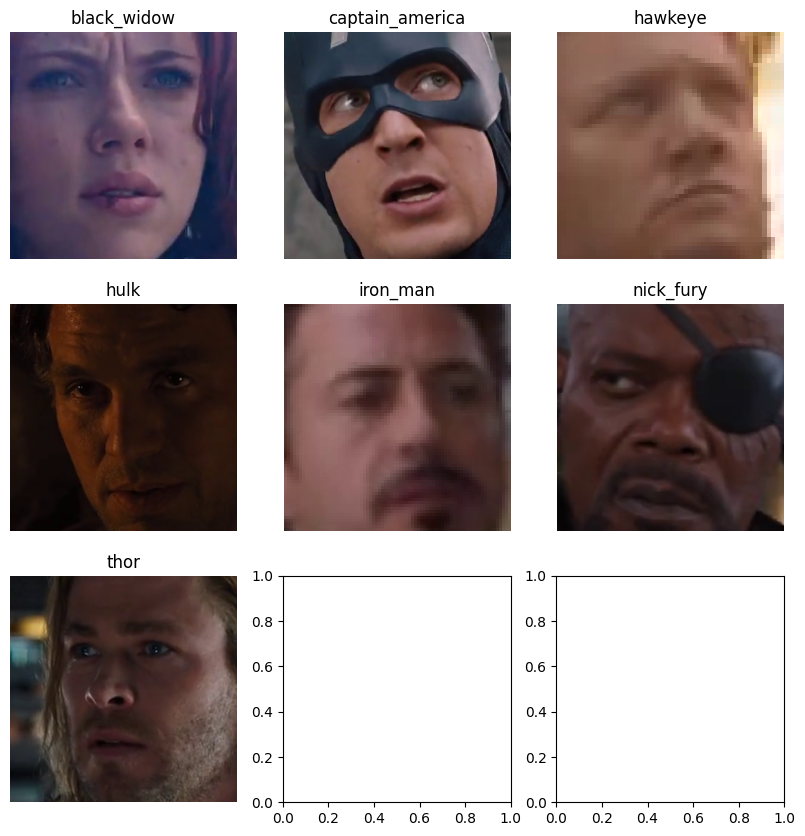

In [ ]:
samples = df.groupby('label').sample()

fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, (index, row) in enumerate(samples.iterrows()):
  ax = axes[i // 3, i % 3]
  ax.imshow(row['image'])
  ax.set_title(row['label'])
  ax.axis('off')
plt.show()



---



#Actividad 2: pre-procesamiento de los datos

---


En esta actividad se va a pre-procesar el dataset almacenado en el dataframe `df`, para extraer caracteristicas que sean utiles para el entrenamiento de los modelos. Para ello, se va a utilizar la librería `face_recognition`, que permite extraer landmarks de una cara, es decir, puntos que representan rasgos faciales como los ojos, la nariz, la boca, etc. Ademas, se va a obtener el encoding de cada imagen, que es un conjunto de puntos que caracterizan la informacion de la cara de una persona. Para esto ultimo se obtendra la media de estos puntos.

Para realizar este pre-procesamiento, se va a crear un nuevo dataframe llamado `df_landmarks`, que tendra las siguientes columnas: `chin`, `left_eyebrow`, `right_eyebrow`, `nose_bridge`, `nose_tip`, `left_eye`, `right_eye`, `top_lip`, `bottom_lip`, `encoding` y `label`. Cada columna contendra los landmarks o el encoding correspondiente a cada imagen del dataframe original `df`.

Para obtener los landmarks y el encoding de cada imagen, se va a usar un bucle `for` que recorra el dataframe original `df` y aplique las funciones `fr.face_landmarks` y `fr.face_encodings` a cada imagen. Estas funciones devuelven una lista de diccionarios con los landmarks y una lista de puntos respectivamente. Para lo anterior, se asumira que cada imagen tiene solo una cara, por lo tanto se tomara el primer elemento de cada lista como resultado. Luego, se guardara el resultado en el dataframe `df_landmarks`.

Sin embargo, puede haber casos en que las funciones `fr.face_landmarks` y `fr.face_encodings` no logren extraer los landmarks o el encoding de una imagen, ya sea porque la cara no es visible o porque la funcion no es capaz de reconocerla. Para manejar estos casos, se usara un bloque `try-catch` que capture esta excepcion. Luego dentro del bloque `except`, se tendra un registro de los ndices de aquellas imagenes sin landmarks o encoding, junto con un contador para llevar una estadística.

In [ ]:
columns = ['chin', 'left_eyebrow', 'right_eyebrow', 'nose_bridge', 'nose_tip', 'left_eye', 'right_eye', 'top_lip', 'bottom_lip', 'encoding', 'label']
df_landmarks = pd.DataFrame(columns=columns)

no_landmark_count = 0
no_landmark_indexes = []

for index, row in df.iterrows():
  image = row["image"]
  label = row["label"]

  image_landmarks = fr.face_landmarks(image)

  try:
    face_encoding_mean = fr.face_encodings(image)[0].mean()
    df_landmarks.loc[index] = [image_landmarks[0][feature] for feature in columns[:-2]] + [face_encoding_mean] + [label]
  except IndexError as e:
    no_landmark_count += 1
    no_landmark_indexes.append(index)

df_landmarks.to_pickle('df_landmarks.pkl')

### Cantidad de datos sin landmark

---



> Cantidad de imagenes sin landmark

In [ ]:
no_landmark_count

2048

> Con esta celda se carga el dataframe de landmarks `df_landmarks` en caso de estar descargado como pickle

In [2]:
def load_landmarks():
  return pd.read_pickle('df_landmarks.pkl')

df_landmarks = load_landmarks()

> En esta celda se retiran todas aquellas filas segun los indices obtenidos para aquellas sin landmark. Esto fue hecho para mantener consistencia entre el dataframe de landmarks y el dataframe original.

In [ ]:
df_clean = df[~df.index.isin(no_landmark_indexes)]
df_clean.to_pickle('df_clean.pkl')

### Balance de clases para el dataset preprocesado

---

A continuacion se mostrara la frecuencia de clases en el dataset sin aquellas filas sin landmark

In [ ]:
df_clean_value_pctgs = df_clean['label'].value_counts(normalize=True)
print(df_clean_value_pctgs)
print("\n __________ Diferencias porcentuales ___________")

diff_freq = df_clean_value_pctgs - df_value_pctgs
percent_diff = (diff_freq / df_value_pctgs) * 100
print(percent_diff)

iron_man           0.311254
captain_america    0.164416
black_widow        0.158628
thor               0.155627
hulk               0.147696
hawkeye            0.049089
nick_fury          0.013290
Name: label, dtype: float64

 __________ Diferencias porcentuales ___________
black_widow        -6.426159
captain_america    -7.560830
hawkeye           -12.821643
hulk                1.586127
iron_man           12.699473
nick_fury         -61.377115
thor               10.904896
Name: label, dtype: float64


Despues del preprocesamiento de los datos, se observa que la distribucion de clases cambio respecto al dataframe original. Algunas clases aumentaron su frecuencia relativo al dataset, mientras que otras disminuyeron.

En particlar, se puede ver que la clase `nick_fury` sufrio de una gran disminucion de imagenes, lo que la hace aun menos frecuente que antes. Por el contrario, las clases `iron_man` y `thor` aumentaron su frecuencia relativa al dataset, lo que las hace mas predominantes. Esto implica que el dataset sigue estando desbalanceado y que el problema de sesgo y generalizacion podria incluso agravarse.

### Decision de datos sin landmark


---


Se decidio eliminar estas imagenes del dataframe, ya que no aportaban información util en este contexto. Ademas, se considero que mantener estas imagenes podria introducir ruido o sesgo innecesariamente, posiblemente dificultando el proceso de entrenamiento y evalaucion de los modelos. Como se menciono antes, se creo un nuevo dataframe `df_clean` unicamente con filas de imagenes qeu contaban con landmarks.

De la mano con lo anterior, se aprovechara la oportunidad de estudiar y analizar los efectos de entrenar modelos usando datasets desbalanceados, con el proposito de entender las limitaciones, dsafios y las oportunidades que se presentan en este tipo de escenarios.



### Muestreo de imagenes por clase


---
A continuacion se mostrara una imagen al azar por cada clase junto con sus landmarks.

In [ ]:
samples = df_clean.groupby('label').sample()

fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, (index, row) in enumerate(samples.iterrows()):
  ax = axes[i // 3, i % 3]
  ax.imshow(row['image'])
  ax.set_title(row['label'])
  ax.axis('off')

  landmarks = df_landmarks.loc[index]
  for name in columns[:-2]:
    x, y = zip(*landmarks[name])
    ax.plot(x, y, 'r. ')


plt.show()



---


#Actividad 3: creando las features

Para elegir buenas features en este contexto, es importante tener en cuenta los siguientes aspectos:

1. **La variabilidad de las fotos.** No todas las fotos son iguales. Incluso para una misma clase, existen numerosas diferencias en iluminacion, tamano, angulo de la cara, zoom de la cara, entre otras. Por lo tanto, hay que tener mucho cuidado al extraer caracteristicas que sean robustas y consistentes ante estas variaciones.
2. **La independencia de la iluminación y la rotacion.** Se buscara hacer caracteristicas que no dependan de la iluminacion ni de la rotacion de las imagenes, ya que estos factores pueden alterar la apariencia de las caras y dificultar su identificacion.
3. **La normalizacion del tamano.** Se analizara el comportamiento de las caracteristicas con y sin normalizacion del tamano de las imagenes (ambos para poder estudiar los resultados), ya que este factor puede afectar a la escala y la proporcion de las caras y sus rasgos.
4. **Las proporciones dentro de la cara.** Se buscaran proporciones entre diferentes partes o puntos de la cara y no valores absolutos, ya que estas pueden ser mas representativas e invariantes que los valores individuales. Por ejemplo, la razon entre el largo de las cejas y el largo de la boca, o la razon de la varianza de las distancias de la barbilla al centro de la nariz sobre el área de los landmarks, entre otras.

Estos son los criterios que se seguirán para diseñar las features.

### Funciones de utilidad para la extraccion de features


---


A continuacion se definen algunas funciones de utilidad que se usaran en la seccion de extraccion de caracteristicas.

In [3]:
def euclidean_distance(p1, p2):
    """
    funcion que calcula la distancia euclidiana entre dos puntos
    """
    p1 = np.array(p1)
    p2 = np.array(p2)

    return distance.euclidean(p1, p2)


def midpoint(p1, p2):
    """
    funcion que calcula el punto medio entre dos puntos
    """
    p1 = np.array(p1)
    p2 = np.array(p2)

    mid = (p1 + p2) / 2

    return tuple(mid)


def extreme_points_x(points):
    """
    funcion que encuentra los puntos mas extremos en el eje x de un arreglo de puntos
    """
    points = np.array(points)

    min_x = np.argmin(points[:,0])
    max_x = np.argmax(points[:,0])

    return points[min_x], points[max_x]


def extreme_points_y(points):
    """
    funcion que encuentra los puntos mas extremos en el eje y de un arreglo de puntos
    """
    points = np.array(points)

    min_y = np.argmin(points[:,1])
    max_y = np.argmax(points[:,1])

    return points[min_y], points[max_y]


def landmarks_area(landmarks):
    """
    funcion que calcula el area de los landmarks como un poligono
    """
    points = landmarks_to_points(landmarks)
    area = polygon_area(points)
    return area


def landmarks_to_points(landmarks):
    """
    funcion que convierte los landmarks en una lista de puntos
    """
    points = []
    points.extend(landmarks["chin"])
    points.extend(landmarks["left_eyebrow"])
    points.extend(landmarks["right_eyebrow"])
    points.extend(landmarks["nose_bridge"])
    points.extend(landmarks["nose_tip"])
    points.extend(landmarks["left_eye"])
    points.extend(landmarks["right_eye"])
    points.extend(landmarks["top_lip"])
    points.extend(landmarks["bottom_lip"])
    return points


def polygon_area(points):
    """
    funcion que calcula el area de un poligono dado una lista de puntos
    extraida de: https://stackoverflow.com/questions/24467972/calculate-area-of-polygon-given-x-y-coordinates
    """
    n = len(points)
    area = 0.0
    for i in range(n):
        j = (i + 1) % n
        area += points[i][0] * points[j][1]
        area -= points[j][0] * points[i][1]
    area = abs(area) / 2.0
    return area

def normalized_feature(feature, landmarks):
    area = landmarks_area(landmarks)
    return int(feature / area)

### Extraccion de caracteristicas


---

En general, la idea a la hora de decidir que caracteristicas calcular fue intentar utilizar toda la informacion entregada por los landmarks. Por esa razon, se intento cubrir la mayor cantidad de informacion relativa a los datos con que se contaban.



*   `eye_eyebrow_ratio`: Esta caracteristica busca medir la proporcion entre el ancho de los ojos y el ancho de las cejas. Se calcula la distancia entre los puntos medios de cada ojo, y la distancia entre los puntos mas extremos de cada ceja. Luego se divide la primera distancia por la segunda, obteniendo asi una razin que representa el taman relativo de los ojos respecto a las cejas. Esta caracteristica puede ser util para diferenciar caras con ojos grandes o pequenos, o con cejas gruesas o delgadas.

*   `eyebrow_chin_ratio`: Esta caracteristica busca medir la proporcion entre el ancho de las cejas y el alto de la cara. Se calcula la distancia entre los puntos mas extremos de cada ceja, y la distancia entre los puntos mas anchos de la barbilla. Luego se dividen ambos valores para obtener una proporcion. Esta caracteristica puede ayudar a caracterizar la forma de la cara relativo a su ancho y las cejas, a traves de la relacion de estas dos.

*   `nose_face_relation`: Esta caracteristica busca medir la proporcion entre el largo de la nariz y el largo de la cara. Se calcula la distancia entre los puntos mas altos y mas bajos de la nariz, y la distancia entre los puntos mas altos y mas bajos de la cara (a traves de las cejas y la barbilla). Luego se dividen ambos valores para obtener un a razon. Esta caracteristica busca diferenciar caras con narices largas o cortas, junto con caras altas o achatadas.

*   `eye_mouth_relation`: Esta caracteristica busca medir la proporcion entre la altura de la boca y la altura de la parte inferior de la cara. Se calcula el punto medio de cada ojo, el punto medio de la boca y el punto medio de la barbilla. Luego se calcula la distancia promedio entre los puntos medios de los ojos y el punto medio de la boca, y la distancia entre el punto medio de la barbilla y el punto medio de la boca. Luego se dividen ambos valores para obtener una razon. Esta caracteristica busca obtener un valor para caracterizar la posicion relativa de los ojos y la boca en la cara.

*   `get_encoding`: Este es el valor retornado por `fr.face encodings`. Se usara como un valor para caracterizar las caras de forma general.

*   `chin_points_to_nose_variance`: Esta caracteristica busca medir la variabilidad de las distancias entre los puntos del chin y el punto medio de la nariz. Se calcula el punto medio `nose_tip`, y luego se calcula la distancia euclidiana entre este punto y cada uno de los puntos de la barbila. Luego se calcula la varianza de estas distancias, obteniendo asi una medida que representa como se distribuyen los puntos del chin alrededor del centro de la nariz. Finalmente se divide este valor por el area encerrada por los landmarks (esta funcion esta definida en las funciones de utilidad). Con esto se busca caracterizar la forma del contorno de la cara a partir de la uniformidad de los puntos de la barbilla al centro de la boca. Con esto se espera diferenciar caras mas ovaladas de caras mas cuadradas.

*   `eyebrows_to_eyes_variance`: Esta caracteristica busca medir la variabilidad de las distancias entre los puntos de las cejas y los puntos medios de los ojos. Se calcula el punto medios de cada ojo, y luego se calcula la distancia euclidiana entre este punto y cada uno de los puntos de cada ceja. Luego se calcula la varianza promedio de estas distancias, y se divide en el area de los landmarks. Con eseto se busca caracterizar la distancia de los ojos a sus cejas mas cercanas, que puede ser util para diferenciar caras con cejas rectas o curvas, o bien caras con cejas cercanas o lejanas a los ojos.

*   `face_width_to_height_ratio`: Esta caracteristica busca medir la proporcion entre el ancho de la cara y el alto de la cara. Se calcula la distancia entre los puntos mas extremos de la barbilla en el eje x, y la distancia entre los puntos mas altos de las cejas y el punto mas bajo d la barbilla en el eje y. Luego se obtiene la razon entre ambos valores. Con esto se busca caracterizar la forma de la cara, diferenciando caras cuadradas de caras mas redondas.

*   `eyebrows_to_nose_variance`: Esta caracteristica busca medir la variabilidad de las distancias entre los puntos de las cejas y el punto medio de la nariz. Se calcula el punto medio de la punta de la nariz, y luego se calcula la distancia euclidiana entre este punto y cada uno de los puntos de cada ceja. Luego se calcula la varianza promedio de estas distancias, y luego este valor se divide por el area encerrada por los landmarks. Esta caracteristica busca caracterizar la posicion de las cejas respecto a la nariz, dando una idea relativa de la disposicion de la cara.

*   `chin_to_nose_variance`: Esta caracteristica busca medir la variabilidad de las distancias entre los puntos de la barbila y el punto medio de la nariz. Se calcula el punto medio de la punta de la nariz, y luego se calcula la distancia euclidiana entre este punto y cada uno de los puntos de la barbilla. Luego se calcula la varianza de estas distancias,y nuevamente se divide por el area del poligono que encierra a los landmarks. Esta caracteristica busca profundizar en la caracterizacion del contorno de la cara, a traves de la distribucion de cada punto de la barbilla a la nariz.




### Codigo para las caracteristicas


---


La mayoria de las caracteristicas tiene la opcion de ser normalizadas a traves de sus parametros. Esto fue realizado para analizar los resultados usando normalizacion.

Por otro lado, todas las funciones siguen la misma logica:

0. Cada funcion recibe dos parametros: `landmarks` y `normalized`. El primero corresponde a los puntos para cada columna del dataframe `df_landmarks`. El segundo corresponde a un valor booleano para decidir si el calculo de la feature sera normalizado.
1. Obtener los puntos extremos de un landmark usando `extreme_points_x` o `extreme_point_y`.
2. Obtener el punto medio usando los puntos obtenidos en el paso anterior a traves de `midpoint`.
3. Obtener alguna metrica en funcion de los valores anteriores.

In [4]:
def eye_eyebrow_ratio(landmarks, normalized):
    """
    funcion que calcula la razon entre la distancia de los puntos medios de los ojos y la distancia entre los extremos de las cejas
    """

    left_eyebrow = landmarks["left_eyebrow"]
    right_eyebrow = landmarks["right_eyebrow"]
    left_eye = landmarks["left_eye"]
    right_eye = landmarks["right_eye"]

    left_eye_min_x, left_eye_max_x = extreme_points_x(left_eye)
    right_eye_min_x, right_eye_max_x = extreme_points_x(right_eye)

    left_eyebrow_min_x, left_eyebrow_max_x = extreme_points_x(left_eyebrow)
    right_eyebrow_min_x, right_eyebrow_max_x = extreme_points_x(right_eyebrow)

    left_eye_mid = midpoint(left_eye_min_x, left_eye_max_x)
    right_eye_mid = midpoint(right_eye_min_x, right_eye_max_x)

    eye_dist = euclidean_distance(left_eye_mid, right_eye_mid)
    eyebrow_dist = euclidean_distance(left_eyebrow_min_x, right_eyebrow_max_x)

    return eye_dist / eyebrow_dist if not normalized else normalized_feature(eye_dist / eyebrow_dist, landmarks)


def eyebrow_chin_ratio(landmarks, normalized):
    """
    funcion que calcula la razon entre la distancia de los puntos mas extremos de las cejas y los puntos mas extremos de la barbilla
    """
    left_eyebrow = landmarks["left_eyebrow"]
    right_eyebrow = landmarks["right_eyebrow"]
    chin = landmarks["chin"]

    left_eyebrow_min_x, left_eyebrow_max_x = extreme_points_x(left_eyebrow)
    right_eyebrow_min_x, right_eyebrow_max_x = extreme_points_x(right_eyebrow)

    chin_min_y, chin_max_y = extreme_points_y(chin)

    eyebrow_dist = euclidean_distance(left_eyebrow_min_x, right_eyebrow_max_x)
    chin_dist = euclidean_distance(chin_min_y, chin_max_y)

    ratio = eyebrow_dist / chin_dist

    return ratio if not normalized else normalized_feature(ratio, landmarks)


def nose_face_relation(landmarks, normalized):
    """
    funcion que calcula la razon entre el largo de la nariz y el largo de la cara
    """

    nose_bridge = landmarks["nose_bridge"]
    chin = landmarks["chin"]
    left_eyebrow = landmarks["left_eyebrow"]
    right_eyebrow = landmarks["right_eyebrow"]

    min_nose_y, max_nose_y = extreme_points_y(nose_bridge)

    _, max_left_eyebrow_y = extreme_points_y(left_eyebrow)
    _, max_right_eyebrow_y = extreme_points_y(right_eyebrow)

    min_chin_y, _ = extreme_points_y(chin)

    max_y_point = np.maximum(max_left_eyebrow_y, max_right_eyebrow_y)

    face_length = euclidean_distance(min_chin_y, max_y_point)
    nose_length = euclidean_distance(min_nose_y, max_nose_y)

    ratio = nose_length / face_length

    return ratio if not normalized else normalized_feature(ratio, landmarks)


def eye_mouth_relation(landmarks, normalized):
    """
    funcion que calcula la razon entre la distancia desde el punto medio de los ojos a el punto medio de la boca y la distancia entre el punto medio
    la barbilla y el punto medi de la boca
    """
    left_eye = landmarks["left_eye"]
    right_eye = landmarks["right_eye"]
    top_lip = landmarks["top_lip"]
    bottom_lip = landmarks["bottom_lip"]
    chin = landmarks["chin"]

    left_eye_min_x, left_eye_max_x = extreme_points_x(left_eye)
    right_eye_min_x, right_eye_max_x = extreme_points_x(right_eye)
    _, top_lip_max_y = extreme_points_y(top_lip)
    bottom_lip_min_y, _ = extreme_points_y(bottom_lip)
    chin_min_x, chin_max_x = extreme_points_x(chin)

    left_eye_mid = midpoint(left_eye_min_x, left_eye_max_x)
    right_eye_mid = midpoint(right_eye_min_x, right_eye_max_x)
    mouth_mid = midpoint(bottom_lip_min_y, top_lip_max_y)
    chin_mid = midpoint(chin_min_x, chin_max_x)

    eye_mouth_dist = (euclidean_distance(left_eye_mid, mouth_mid) + euclidean_distance(right_eye_mid, mouth_mid)) / 2
    chin_mouth_dist = euclidean_distance(chin_mid, mouth_mid)

    eye_mouth_relation = eye_mouth_dist / chin_mouth_dist

    return eye_mouth_relation if not normalized else normalized_feature(eye_mouth_relation, landmarks)


def get_encoding(landmarks):
    """
    funcion que retorna la codificacion de los landmarks
    """
    encoding = landmarks["encoding"]

    return encoding


def chin_points_to_nose_variance(landmarks, normalized):
    """
    funcion que calcula la varianza de la distancie entre cada punto de la barbilla y el punto medio de la nariz
    """
    nose_tip = landmarks["nose_tip"]
    chin = landmarks["chin"]

    nosetip_mostleft_x, nosetip_mostright_x = extreme_points_x(nose_tip)

    nose_tip_mid = midpoint(nosetip_mostleft_x, nosetip_mostright_x)

    chin_variance = np.var([euclidean_distance(point, nose_tip_mid) for point in chin])

    return chin_variance



def eyebrows_to_eyes_variance(landmarks, normalized):
    """
    funcion que calcula la varianza de la distancia entre los puntos de las cejas y el punto medio del ojo mas cercano a la ceja
    """
    left_eyebrow = landmarks["left_eyebrow"]
    right_eyebrow = landmarks["right_eyebrow"]
    left_eye = landmarks["left_eye"]
    right_eye = landmarks["right_eye"]

    left_eye_min_x, left_eye_max_x = extreme_points_x(left_eye)
    right_eye_min_x, right_eye_max_x = extreme_points_x(right_eye)

    left_eye_mid = midpoint(left_eye_min_x, left_eye_max_x)
    right_eye_mid = midpoint(right_eye_min_x, right_eye_max_x)

    left_eyebrow_variance = np.var([euclidean_distance(point, left_eye_mid) for point in left_eyebrow])
    right_eyebrow_variance = np.var([euclidean_distance(point, right_eye_mid) for point in right_eyebrow])

    eyebrows_to_eyes_variance = (left_eyebrow_variance + right_eyebrow_variance) / 2

    return eyebrows_to_eyes_variance


def face_width_to_height_ratio(landmarks, normalized):

    """
    funcion que calcula la razon entre el largo de la cara y el ancho de la cara.
    """
    chin = landmarks["chin"]
    left_eyebrow = landmarks["left_eyebrow"]
    right_eyebrow = landmarks["right_eyebrow"]

    leftmost_point, rightmost_point = extreme_points_x(chin)
    lowest_point, _ = extreme_points_y(chin)
    _, highest_left_eyebrow_point = extreme_points_y(left_eyebrow)
    _, highest_right_eyebrow_point = extreme_points_y(right_eyebrow)
    highest_point = max(highest_left_eyebrow_point[1], highest_right_eyebrow_point[1])

    face_width = np.linalg.norm(leftmost_point - rightmost_point)
    face_height = np.linalg.norm(lowest_point - highest_point)

    ratio = face_width / face_height

    return ratio if not normalized else normalized_feature(ratio, landmarks)



def eyebrows_to_nose_variance(landmarks, normalized):
    """
    funcion que calcula la varianza de la distancia de los puntos de las cejas al punto medio de la nariz
    """
    left_eyebrow = landmarks["left_eyebrow"]
    right_eyebrow = landmarks["right_eyebrow"]
    nose_tip = landmarks["nose_tip"]

    nosetip_mostleft_x, nosetip_mostright_x = extreme_points_x(nose_tip)

    nose_tip_mid = midpoint(nosetip_mostleft_x, nosetip_mostright_x)

    left_eyebrow_variance = np.var([euclidean_distance(point, nose_tip_mid) for point in left_eyebrow])
    right_eyebrow_variance = np.var([euclidean_distance(point, nose_tip_mid) for point in right_eyebrow])

    eyebrows_to_nose_variance = (left_eyebrow_variance + right_eyebrow_variance) / 2

    return eyebrows_to_nose_variance


def chin_to_nose_variance(landmarks, normalized):
    """
    funcion que calcula la varianza de la distancia de los puntos de la barbilla al punto medio de la nariz
    """
    chin = landmarks["chin"]
    nose_tip = landmarks["nose_tip"]

    nosetip_mostleft_x, nosetip_mostright_x = extreme_points_x(nose_tip)

    nose_tip_mid = midpoint(nosetip_mostleft_x, nosetip_mostright_x)

    chin_variance = np.var([euclidean_distance(point, nose_tip_mid) for point in chin])

    return chin_variance


# Actividad 4: entrenamiento de los modelos


---



### Funciones de utilidad para obtener las caracteristicas


---



In [5]:
def get_features(landmarks, normalized):
    """
    funcion que calcula las features de una imagen
    """
    eye_eyebrow_ratio1 = eye_eyebrow_ratio(landmarks, normalized)
    eyebrow_chin_ratio1 = eyebrow_chin_ratio(landmarks, normalized)
    nose_face_relation1 = nose_face_relation(landmarks, normalized)
    eye_mouth_relation1 = eye_mouth_relation(landmarks, normalized)
    chin_points_to_nose_variance1 = chin_points_to_nose_variance(landmarks, normalized)
    eyebrows_to_eyes_variance1 = eyebrows_to_eyes_variance(landmarks, normalized)
    get_encoding1 = get_encoding(landmarks)
    face_width_to_height_ratio1 = face_width_to_height_ratio(landmarks, normalized)
    eyebrows_to_nose_variance1 = eyebrows_to_nose_variance(landmarks, normalized)
    chin_to_nose_variance1 = chin_to_nose_variance(landmarks, normalized)

    features = pd.Series([eye_eyebrow_ratio1, eyebrow_chin_ratio1,
                          nose_face_relation1, eye_mouth_relation1, chin_points_to_nose_variance1,
                          eyebrows_to_eyes_variance1, face_width_to_height_ratio1,
                          eyebrows_to_nose_variance1, chin_to_nose_variance1, get_encoding1])

    return features


def get_features_df(df, normalized):
    """
    funcion que calcula las features de un dataframe de imagenes
    """
    features = df.apply(get_features, axis=1, normalized=normalized)

    return features

## Modelos a entrenar:


---


1. **Arboles de decision**
2. **Random Forests**
3. **Gradient Boosting**
4. **KNN**
5. **SVM**

### Vector de labels y de features nomalizadas y no normalizadas

---



In [6]:
X = get_features_df(df_landmarks, False)
X_norm = get_features_df(df_landmarks, True)
y = df_landmarks["label"]

### Separacion de training y testing


---
Se usara un `90%` de los datos para training y el `10%` restante para training porque se pretenede darle enfasis al entrenamiento y aprovechar al maximo la cantidad de datos disponibles para ajustar el modelo, sobre todo porque existe un gran desbalance para algunas clases, lo que podria generar sesgo en el modelo tal como se ha mencionado antes. Ademas, esta proporcion sigue la linea de valores usado para el train y test usado en las ayudantias del curso, que usan entre un `10%` y `30%` para testing, dependiendo del tamano de los datos y la complejidad del problema. En suma, se eligio esta proporcion para minimizar el sesgo e intentar alimentar al modelo con la mayor cantidad de datos posibles, mantiendo una cantidad razonable para el testing.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [10]:
X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(X_norm, y, test_size=0.1)

## Hiperparametros a estudiar por cada modelo

---

A continuacion se muestran los parametros elegidos por cada modelo luego de leer la documentacion. Cada parametro fue elegido segun si su variacion era relevante para el problema.

1. **Arboles de decision** [[fuente](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)]


*   `criterion`: mide la calidad de una particion en el arbol. Se puede usar `gini`, `entropy`, `log_loss`. Por defecto se usa `gini`.
*  `max_depth`: define la maxima profundidad que puede tener el arbol. Si no se toca este parametro entonces se expande hasta que todas las hojas sean puras.

---

2. **Random Forests** [[fuente](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)]
*   `criterion`: los mismos que para arboles de decision.

*  `max_depth`: lo mismo que para arboles de decision.
*  `n_estimators`: este parametro define la cantidad de arboles que tendra el bosque. Por defecto es `100`.
* `class_weight`: es posible entregar un diccionario para dar diferentes a pesos a las clases, o bien se puede usar el parametro `balanced` que le da el mismo peso a todas las clases. En ese caso si hay un desbalance, `balanced` le dara mas peso a aquellas clases mas desbalanceadas. Luego por defecto todas las clases tienen peso `1`. Este parametro es particularmente intersante para el caso de este colab ya que existe inherentemente un gran desbalance de clases.

---
3. **Gradient Boosting** [[fuente](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)]
* `criterion`: nuevamente se refiere a una funcion capaz de medir la calidad de una particion de un arbol. Se menciona en la documentacion que el metodopor defecto `friedman_mse` es usualmente el mejor, por lo tanto no se modificara este parametro.
*   `loss`: representa la funcion de perdida a ser optimizada. Se usara el valor por defecto `log_loss` que segun la documentacion es bueno para problemas con salidas probabilisticas. No se usara `exponential` ya que tiraba ciertos erores.
*  `*learning_rate`: este parametro controla la velocidad de aprendizaje del meodelo. En general, a valores bajos se le da menos contribucion a los arboles, por lo tanto existe una cierta dependencia entre `n_estimators` y `learning_rate`: este parametro indica es el peso que se aplica a cada arbol en cada iteracion. Es decir, a valores bajos la contribucion de cada arbol es menor. Este valor esta sujeto de cierta forma a `n_estimators` ya que a menor `learning_rate` se necesita un mayor `n_estimators``
*    `n_estimators`: numero de arboles que se construyen.


---
4. **KNN** [[fuente](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)]
*   `n_neighbors`: es la cantidad de vecinos mas cercanos que se consideraran a la hora de clasificar una muestra.
*  `weights`: representa la funcion de peso que se ocupara en las predicciones. Existen dos tipos: `uniform` y `distance` donde el primero le da el mismo peso a todos las muestras de la vecindad, mientras que el segundo le da peso a las muestras segun el inverso de su distancia, implicando que los vecinos mas cercanos tendran preferencia.
* `algorithm`: representa el algoritmo que se usara para computar al vecino mas cercano. Estan disponibles `ball_tree`, `kd_tree` y `auto`. Sin embargo `auto` intenta por defecto elegir el algoritmo mas adecuado para el problema por lo que solo se usara este valor para `algorithm`.
* `metric`: se pueden elegir diferentes metricas para calcular distancias. En particular estan disponibles `euclidean` que calcula la distancia en linea recta entre dos puntos, `manhattan` que calcula la distancia recorriendo a traves de cuadriculas, `minkowski` que es la distancia por defecto y depende de otro parametro `p`. En particular cuando este parametro es `2` `minkowski` funciona como `euclidean` pero cuando el `p` es grande tiende a la distancia de `chebyshev`, que busca la diferencia mas grande en una dimension (por ejemplo si comparamos `(2,5)` con `(-1, -3)` tenemos que la diferencia en el eje `x` es de `3` y la diferencia en el eje `y` es de `8`).
* `p`: segun la documentacion es un parametro netamente para la metrica de `Minkowski`. Se variara para probar.
---
5. **SVM** [[fuente](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)]
*  `C`: este es el parametro que fija la tolerancia al error que se tendra. Un valor alto implica una baja tolerancia al error, mientras que un valor bajo penaliza poco los errores.
*  `kernel`: representa la funcion que se utiliza para transformar los datos a espacios de caracteristicas de mas dimension, en caso de que estas puedan ser mejor separados en diferentes dimensiones a las del problema original. En particular se probara con `linear`, `poly`, `rbf` y `sigmoid`.
*  `degree`: representa el grado del polinomio que se tiene cuando se usa kernel de tipo `poly`.
---




#1. Analisis de los hiperparametros de Arboles de Decision

---



In [ ]:
def evaluate_tree_model(X_train, X_test, y_train, y_test, criteria, depth):
  """
  Funcion adaptada de la ayudantia 8
  https://github.com/IIC2613-Inteligencia-Artificial-2023-1/Syllabus/blob/main/Ayudantia%208/Ayudantia_ia.ipynb
  """
  train_scores = []
  test_scores = []
  values = [i for i in range(1, depth)]

  for i in range(1, depth):
    model = DecisionTreeClassifier(max_depth=i, criterion=criteria, random_state=0)
    model.fit(X_train, y_train)

    train_yhat = model.predict(X_train)
    train_acc = accuracy_score(y_train, train_yhat)
    train_scores.append(train_acc)

    test_yhat = model.predict(X_test)
    test_acc = accuracy_score(y_test, test_yhat)
    test_scores.append(test_acc)

    print("__________________________________________________________")
    print(classification_report(y_test, test_yhat, zero_division=1))
    print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))


  pyplot.plot(values, train_scores, '-o', label='Train')
  pyplot.plot(values, test_scores, '-o', label='Test')
  pyplot.legend()
  pyplot.show()
  print(f"Best test: {max(test_scores)}")

### Evaluacion de Entropia vs Gini


---



#### Resultados para Entropia
Se usa criterio `entropy` y se probara con profundidad de `1` a `15` con datos normalizados y no normalizados.

__________________________________________________________
                 precision    recall  f1-score   support

    black_widow       0.27      0.92      0.42        76
captain_america       1.00      0.00      0.00        81
        hawkeye       1.00      0.00      0.00        21
           hulk       1.00      0.00      0.00        72
       iron_man       0.62      0.90      0.74       144
      nick_fury       1.00      0.00      0.00         2
           thor       1.00      0.00      0.00        71

       accuracy                           0.43       467
      macro avg       0.84      0.26      0.17       467
   weighted avg       0.76      0.43      0.30       467

>1, train: 0.420, test: 0.428
__________________________________________________________
                 precision    recall  f1-score   support

    black_widow       0.55      0.64      0.59        76
captain_america       1.00      0.00      0.00        81
        hawkeye       1.00      0.00      0.00    

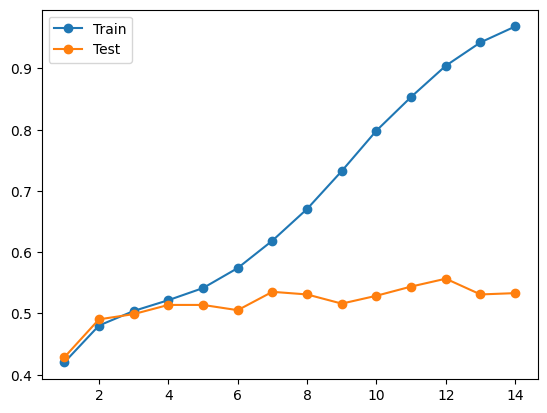

Best test: 0.556745182012848
__________________________ MODELO NORMALIZADO ________________________________
__________________________________________________________
                 precision    recall  f1-score   support

    black_widow       0.27      0.87      0.42        77
captain_america       1.00      0.00      0.00        69
        hawkeye       1.00      0.00      0.00        24
           hulk       1.00      0.00      0.00        60
       iron_man       0.64      0.86      0.73       167
      nick_fury       1.00      0.00      0.00         4
           thor       1.00      0.00      0.00        66

       accuracy                           0.45       467
      macro avg       0.85      0.25      0.16       467
   weighted avg       0.75      0.45      0.33       467

>1, train: 0.418, test: 0.450
__________________________________________________________
                 precision    recall  f1-score   support

    black_widow       0.34      0.66      0.45        77

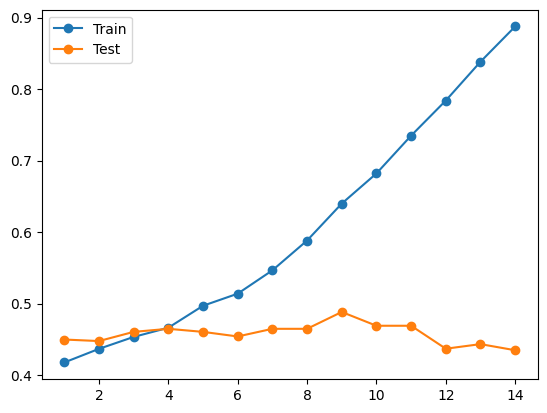

Best test: 0.48822269807280516


In [ ]:
evaluate_tree_model(X_train, X_test, y_train, y_test, "entropy", 15)

print("__________________________ MODELO NORMALIZADO ________________________________")

evaluate_tree_model(X_train_norm, X_test_norm, y_train_norm, y_test_norm, "entropy", 15)

#### Resultados para Gini
Se usa criterio `gini` y se probara con profundidad de `1` a `15` con datos normalizados y no normalizados.

In [ ]:
evaluate_tree_model(X_train, X_test, y_train, y_test, "gini", 15)

print("__________________________ MODELO NORMALIZADO ________________________________")

evaluate_tree_model(X_train_norm, X_test_norm, y_train_norm, y_test_norm, "gini", 15)

__________________________________________________________
                 precision    recall  f1-score   support

    black_widow       0.24      0.93      0.39        76
captain_america       1.00      0.00      0.00        81
        hawkeye       1.00      0.00      0.00        21
           hulk       1.00      0.00      0.00        72
       iron_man       0.66      0.81      0.73       144
      nick_fury       1.00      0.00      0.00         2
           thor       1.00      0.00      0.00        71

       accuracy                           0.40       467
      macro avg       0.84      0.25      0.16       467
   weighted avg       0.77      0.40      0.29       467

>1, train: 0.400, test: 0.403
__________________________________________________________
                 precision    recall  f1-score   support

    black_widow       0.57      0.51      0.54        76
captain_america       0.26      0.72      0.38        81
        hawkeye       1.00      0.00      0.00    

Best test: 0.5738758029978587
__________________________ MODELO NORMALIZADO ________________________________
__________________________________________________________
                 precision    recall  f1-score   support

    black_widow       0.25      0.95      0.40        77
captain_america       1.00      0.00      0.00        69
        hawkeye       1.00      0.00      0.00        24
           hulk       1.00      0.00      0.00        60
       iron_man       0.73      0.77      0.75       167
      nick_fury       1.00      0.00      0.00         4
           thor       1.00      0.00      0.00        66

       accuracy                           0.43       467
      macro avg       0.85      0.24      0.16       467
   weighted avg       0.78      0.43      0.33       467

>1, train: 0.397, test: 0.430
__________________________________________________________
                 precision    recall  f1-score   support

    black_widow       0.35      0.75      0.48        7

Best test: 0.5032119914346895


## **Mejor resultado para Arboles de decision**:
> Profundidad `12` y criterio `gini` sin normalizar con un `accuracy` de `0.574`



---


# 2. Analisis de los hiperparametros de Random Forests

---


In [ ]:
def evaluate_random_forest_model(X_train, X_test, y_train, y_test, criteria, depth, class_weight=None, n_estimators=100):
  """
  Funcion adaptada de la ayudantia 8
  https://github.com/IIC2613-Inteligencia-Artificial-2023-1/Syllabus/blob/main/Ayudantia%208/Ayudantia_ia.ipynb
  """
  train_scores = []
  test_scores = []
  values = [i for i in range(1, depth)]

  for i in range(1, depth):
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=i, criterion=criteria, class_weight=class_weight, random_state=0)
    model.fit(X_train, y_train)

    train_yhat = model.predict(X_train)
    train_acc = accuracy_score(y_train, train_yhat)
    train_scores.append(train_acc)

    test_yhat = model.predict(X_test)
    test_acc = accuracy_score(y_test, test_yhat)
    test_scores.append(test_acc)

    print("__________________________________________________________")
    print(classification_report(y_test, test_yhat, zero_division=1))
    print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))


  pyplot.plot(values, train_scores, '-o', label='Train')
  pyplot.plot(values, test_scores, '-o', label='Test')
  pyplot.legend()
  pyplot.show()
  print(f"Best test: {max(test_scores)}")

### 1. Evaluacion del parametro de peso de clases


---




#### 1.1 Resultados usando el valor por defecto de pesos por clase, es decir, 1.
---
Se usa criterio `entropy` y se probara con profundidad de `1` a `15` con datos normalizados y no normalizados.



In [ ]:
evaluate_random_forest_model(X_train, X_test, y_train, y_test, "entropy", 20)

print("__________________________ MODELO NORMALIZADO ________________________________")

evaluate_random_forest_model(X_train_norm, X_test_norm, y_train_norm, y_test_norm, "entropy", 20)

__________________________________________________________
                 precision    recall  f1-score   support

    black_widow       0.51      0.75      0.61        76
captain_america       1.00      0.00      0.00        81
        hawkeye       1.00      0.00      0.00        21
           hulk       1.00      0.00      0.00        72
       iron_man       0.40      0.98      0.56       144
      nick_fury       1.00      0.00      0.00         2
           thor       1.00      0.00      0.00        71

       accuracy                           0.42       467
      macro avg       0.84      0.25      0.17       467
   weighted avg       0.73      0.42      0.27       467

>1, train: 0.414, test: 0.424
__________________________________________________________
                 precision    recall  f1-score   support

    black_widow       0.50      0.83      0.62        76
captain_america       0.32      0.28      0.30        81
        hawkeye       1.00      0.00      0.00    

Best test: 0.6916488222698073
__________________________ MODELO NORMALIZADO ________________________________
__________________________________________________________
                 precision    recall  f1-score   support

    black_widow       1.00      0.00      0.00        77
captain_america       1.00      0.00      0.00        69
        hawkeye       1.00      0.00      0.00        24
           hulk       1.00      0.00      0.00        60
       iron_man       0.36      1.00      0.53       167
      nick_fury       1.00      0.00      0.00         4
           thor       1.00      0.00      0.00        66

       accuracy                           0.36       467
      macro avg       0.91      0.14      0.08       467
   weighted avg       0.77      0.36      0.19       467

>1, train: 0.306, test: 0.358
__________________________________________________________
                 precision    recall  f1-score   support

    black_widow       0.29      0.83      0.43        7

Best test: 0.5717344753747323


#### 1.2 Resultados usando pesos balanceados para las clases

---

Se usa criterio `entropy` y se probara con profundidad de `1` a `15` y peso balanceado entre clases, con datos normalizados y no normalizados.






__________________________________________________________
                 precision    recall  f1-score   support

    black_widow       0.47      0.62      0.54        76
captain_america       0.36      0.17      0.23        81
        hawkeye       1.00      0.00      0.00        21
           hulk       0.46      0.33      0.39        72
       iron_man       0.66      0.82      0.73       144
      nick_fury       0.00      0.00      0.00         2
           thor       0.31      0.13      0.18        71

       accuracy                           0.45       467
      macro avg       0.47      0.30      0.30       467
   weighted avg       0.51      0.45      0.44       467

>1, train: 0.465, test: 0.454
__________________________________________________________
                 precision    recall  f1-score   support

    black_widow       0.53      0.72      0.61        76
captain_america       0.45      0.11      0.18        81
        hawkeye       1.00      0.00      0.00    

Best test: 0.6916488222698073
__________________________ MODELO NORMALIZADO ________________________________
__________________________________________________________
                 precision    recall  f1-score   support

    black_widow       0.28      0.83      0.42        77
captain_america       0.44      0.06      0.10        69
        hawkeye       1.00      0.00      0.00        24
           hulk       1.00      0.00      0.00        60
       iron_man       0.68      0.80      0.74       167
      nick_fury       0.04      0.25      0.06         4
           thor       0.44      0.06      0.11        66

       accuracy                           0.44       467
      macro avg       0.56      0.29      0.20       467
   weighted avg       0.60      0.44      0.36       467

>1, train: 0.407, test: 0.443
__________________________________________________________
                 precision    recall  f1-score   support

    black_widow       0.30      0.64      0.41        7

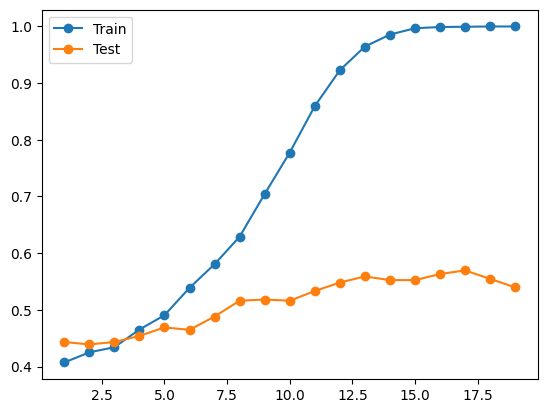

Best test: 0.569593147751606


In [ ]:
evaluate_random_forest_model(X_train, X_test, y_train, y_test, "entropy", 20, "balanced")

print("__________________________ MODELO NORMALIZADO ________________________________")

evaluate_random_forest_model(X_train_norm, X_test_norm, y_train_norm, y_test_norm, "entropy", 20, "balanced")

### 2 Evaluacion del parametro de estimadores


---

#### 2.1 Resultados usando pesos por defecto y `n_estimators` = `150` (por defecto fue usado `100` en las celdas anteriores).

---

Se usa criterio `entropy` y se probara con profundidad de `1` a `15` y peso por defecto entre clases, y `150` arboles, con datos normalizados y no normalizados.








In [ ]:
evaluate_random_forest_model(X_train, X_test, y_train, y_test, "entropy", 20, None, 150)

print("__________________________ MODELO NORMALIZADO ________________________________")

evaluate_random_forest_model(X_train_norm, X_test_norm, y_train_norm, y_test_norm, "entropy", 20, None, 150)

__________________________________________________________
                 precision    recall  f1-score   support

    black_widow       0.54      0.70      0.61        76
captain_america       1.00      0.00      0.00        81
        hawkeye       1.00      0.00      0.00        21
           hulk       1.00      0.00      0.00        72
       iron_man       0.38      0.98      0.55       144
      nick_fury       1.00      0.00      0.00         2
           thor       1.00      0.00      0.00        71

       accuracy                           0.42       467
      macro avg       0.85      0.24      0.17       467
   weighted avg       0.73      0.42      0.27       467

>1, train: 0.409, test: 0.415
__________________________________________________________
                 precision    recall  f1-score   support

    black_widow       0.52      0.80      0.63        76
captain_america       0.33      0.31      0.32        81
        hawkeye       1.00      0.00      0.00    

Best test: 0.6916488222698073
__________________________ MODELO NORMALIZADO ________________________________
__________________________________________________________
                 precision    recall  f1-score   support

    black_widow       1.00      0.00      0.00        77
captain_america       1.00      0.00      0.00        69
        hawkeye       1.00      0.00      0.00        24
           hulk       1.00      0.00      0.00        60
       iron_man       0.36      1.00      0.53       167
      nick_fury       1.00      0.00      0.00         4
           thor       1.00      0.00      0.00        66

       accuracy                           0.36       467
      macro avg       0.91      0.14      0.08       467
   weighted avg       0.77      0.36      0.19       467

>1, train: 0.306, test: 0.358
__________________________________________________________
                 precision    recall  f1-score   support

    black_widow       0.29      0.83      0.43        7

Best test: 0.569593147751606


#### 2.2 Resultados usando `n_estimators` = `200`.

---

In [ ]:
evaluate_random_forest_model(X_train, X_test, y_train, y_test, "entropy", 20, None, 200)

print("__________________________ MODELO NORMALIZADO ________________________________")

evaluate_random_forest_model(X_train_norm, X_test_norm, y_train_norm, y_test_norm, "entropy", 20, None, 200)

__________________________________________________________
                 precision    recall  f1-score   support

    black_widow       0.56      0.70      0.62        76
captain_america       1.00      0.00      0.00        81
        hawkeye       1.00      0.00      0.00        21
           hulk       1.00      0.00      0.00        72
       iron_man       0.38      0.98      0.55       144
      nick_fury       1.00      0.00      0.00         2
           thor       1.00      0.00      0.00        71

       accuracy                           0.42       467
      macro avg       0.85      0.24      0.17       467
   weighted avg       0.74      0.42      0.27       467

>1, train: 0.408, test: 0.415
__________________________________________________________
                 precision    recall  f1-score   support

    black_widow       0.52      0.79      0.63        76
captain_america       0.33      0.31      0.32        81
        hawkeye       1.00      0.00      0.00    

Best test: 0.6895074946466809
__________________________ MODELO NORMALIZADO ________________________________
__________________________________________________________
                 precision    recall  f1-score   support

    black_widow       1.00      0.00      0.00        77
captain_america       1.00      0.00      0.00        69
        hawkeye       1.00      0.00      0.00        24
           hulk       1.00      0.00      0.00        60
       iron_man       0.36      1.00      0.53       167
      nick_fury       1.00      0.00      0.00         4
           thor       1.00      0.00      0.00        66

       accuracy                           0.36       467
      macro avg       0.91      0.14      0.08       467
   weighted avg       0.77      0.36      0.19       467

>1, train: 0.306, test: 0.358
__________________________________________________________
                 precision    recall  f1-score   support

    black_widow       0.29      0.84      0.43        7

Best test: 0.563169164882227


### 3. Evaluacion del criterio
---

#### 3.1 Resultados usando balance de pesos por defecto y `n_estimators` = 150 para `gini` y `log_loss` (ya que `entropy` fue realizado en la celda anterior)






---


In [ ]:
evaluate_random_forest_model(X_train, X_test, y_train, y_test, "gini", 20, None, 200)

print("__________________________ MODELO NORMALIZADO ________________________________")

evaluate_random_forest_model(X_train_norm, X_test_norm, y_train_norm, y_test_norm, "gini", 20, None, 200)

__________________________________________________________
                 precision    recall  f1-score   support

    black_widow       0.59      0.51      0.55        76
captain_america       1.00      0.00      0.00        81
        hawkeye       1.00      0.00      0.00        21
           hulk       1.00      0.00      0.00        72
       iron_man       0.35      0.98      0.52       144
      nick_fury       1.00      0.00      0.00         2
           thor       1.00      0.00      0.00        71

       accuracy                           0.39       467
      macro avg       0.85      0.21      0.15       467
   weighted avg       0.73      0.39      0.25       467

>1, train: 0.393, test: 0.385
__________________________________________________________
                 precision    recall  f1-score   support

    black_widow       0.54      0.70      0.61        76
captain_america       0.32      0.28      0.30        81
        hawkeye       1.00      0.00      0.00    

Best test: 0.683083511777302
__________________________ MODELO NORMALIZADO ________________________________
__________________________________________________________
                 precision    recall  f1-score   support

    black_widow       1.00      0.00      0.00        77
captain_america       1.00      0.00      0.00        69
        hawkeye       1.00      0.00      0.00        24
           hulk       1.00      0.00      0.00        60
       iron_man       0.36      1.00      0.53       167
      nick_fury       1.00      0.00      0.00         4
           thor       1.00      0.00      0.00        66

       accuracy                           0.36       467
      macro avg       0.91      0.14      0.08       467
   weighted avg       0.77      0.36      0.19       467

>1, train: 0.306, test: 0.358
__________________________________________________________
                 precision    recall  f1-score   support

    black_widow       0.29      0.83      0.43        77

Best test: 0.569593147751606


#### 3.2 Resultados usando criterio `log_loss`




__________________________________________________________
                 precision    recall  f1-score   support

    black_widow       0.56      0.70      0.62        76
captain_america       1.00      0.00      0.00        81
        hawkeye       1.00      0.00      0.00        21
           hulk       1.00      0.00      0.00        72
       iron_man       0.38      0.98      0.55       144
      nick_fury       1.00      0.00      0.00         2
           thor       1.00      0.00      0.00        71

       accuracy                           0.42       467
      macro avg       0.85      0.24      0.17       467
   weighted avg       0.74      0.42      0.27       467

>1, train: 0.408, test: 0.415
__________________________________________________________
                 precision    recall  f1-score   support

    black_widow       0.52      0.79      0.63        76
captain_america       0.33      0.31      0.32        81
        hawkeye       1.00      0.00      0.00    

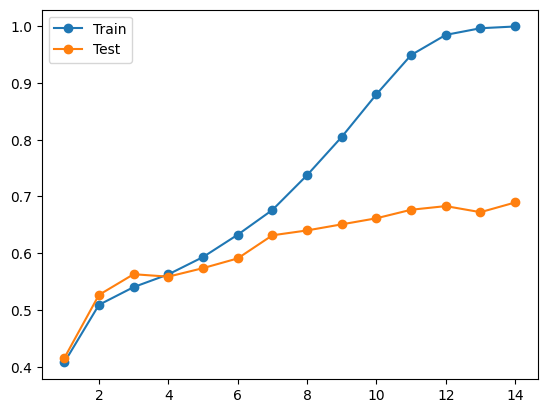

Best test: 0.6895074946466809
__________________________ MODELO NORMALIZADO ________________________________
__________________________________________________________
                 precision    recall  f1-score   support

    black_widow       1.00      0.00      0.00        77
captain_america       1.00      0.00      0.00        69
        hawkeye       1.00      0.00      0.00        24
           hulk       1.00      0.00      0.00        60
       iron_man       0.36      1.00      0.53       167
      nick_fury       1.00      0.00      0.00         4
           thor       1.00      0.00      0.00        66

       accuracy                           0.36       467
      macro avg       0.91      0.14      0.08       467
   weighted avg       0.77      0.36      0.19       467

>1, train: 0.306, test: 0.358
__________________________________________________________
                 precision    recall  f1-score   support

    black_widow       0.29      0.84      0.43        7

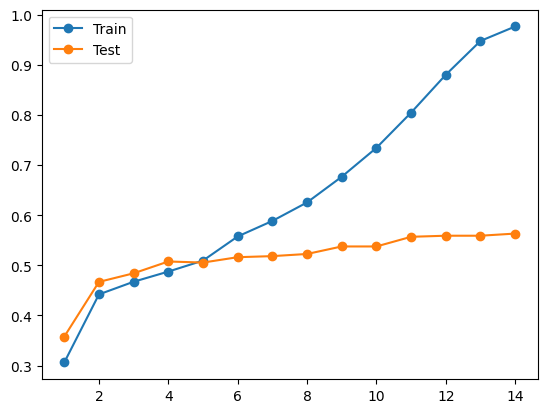

Best test: 0.563169164882227


In [ ]:
evaluate_random_forest_model(X_train, X_test, y_train, y_test, "log_loss", 15, None, 200)

print("__________________________ MODELO NORMALIZADO ________________________________")

evaluate_random_forest_model(X_train_norm, X_test_norm, y_train_norm, y_test_norm, "log_loss", 15, None, 200)

## **Mejor resultado para Random Forest**:
> Profundidad 12 con peso de clases por defecto, `n_estimators` = 150 y criterio `entropy` con `accuracy` de `0.6916488222698073`

# Analisis de los hiperparametros de GradientBoostingClassifier

---


In [ ]:
def evaluate_gradient_boosting_classifier(X_train, X_test, y_train, y_test, n_estimators_list, learning_rate = 0.1):
  """
  Funcion adaptada de la ayudantia 8
  https://github.com/IIC2613-Inteligencia-Artificial-2023-1/Syllabus/blob/main/Ayudantia%208/Ayudantia_ia.ipynb
  """
  train_scores = []
  test_scores = []
  values = n_estimators_list

  for i in n_estimators_list:
    model = GradientBoostingClassifier(random_state=0, n_estimators=i, learning_rate=learning_rate)
    model.fit(X_train, y_train)

    train_yhat = model.predict(X_train)
    train_acc = accuracy_score(y_train, train_yhat)
    train_scores.append(train_acc)

    test_yhat = model.predict(X_test)
    test_acc = accuracy_score(y_test, test_yhat)
    test_scores.append(test_acc)
    print("__________________________________________________________")
    print(classification_report(y_test, test_yhat, zero_division=1))
    print('>n_estimators: %d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))


  pyplot.plot(values, train_scores, '-o', label='Train')
  pyplot.plot(values, test_scores, '-o', label='Test')
  pyplot.legend()
  pyplot.show()
  print(f"Best test: {max(test_scores)}")


### 1. Evaluacion de la cantidad de `n_estimators`
---

__________________________________________________________
                 precision    recall  f1-score   support

    black_widow       0.60      0.72      0.65        76
captain_america       0.42      0.37      0.39        81
        hawkeye       0.22      0.10      0.13        21
           hulk       0.65      0.49      0.56        72
       iron_man       0.69      0.90      0.78       144
      nick_fury       0.00      0.00      0.00         2
           thor       0.54      0.37      0.44        71

       accuracy                           0.60       467
      macro avg       0.44      0.42      0.42       467
   weighted avg       0.57      0.60      0.57       467

>n_estimators: 25, train: 0.669, test: 0.595
__________________________________________________________
                 precision    recall  f1-score   support

    black_widow       0.62      0.72      0.67        76
captain_america       0.47      0.40      0.43        81
        hawkeye       0.21      0.1

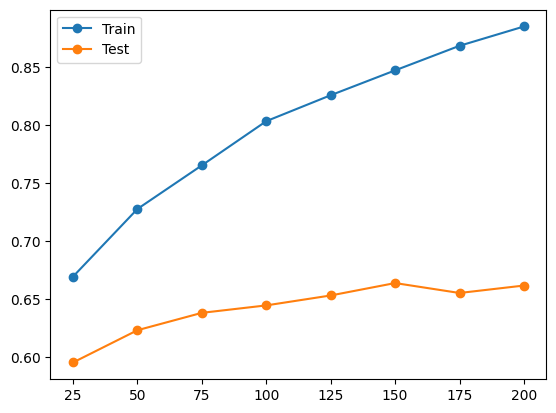

Best test: 0.6638115631691649


In [ ]:
n_estimators_list = [25, 50, 75, 100, 125, 150, 175, 200]
evaluate_gradient_boosting_classifier(X_train, X_test, y_train, y_test, n_estimators_list)


### Comentario


---


Como comentario anecdotico, quiero comentar que en este punto del colab me di cuenta de que la forma en que estaba analizando los hiperparametros no era necesariamente la mejor. Al principio, estaba variando estos hiperparametros de uno en uno, fijando el que diese mejor resultado y continuando al siguiente. Sin embargo, me di cuenta de que esto no estaba bien ya que podia haber una depedencia entre parametros y el orden en que los fijaba podia afectar al resultado final.

Buscando informacion sobre este tema, encontre un [articulo](https://scikit-learn.org/stable/modules/grid_search.html) que hablaba sobre formas de encontrar estos hiperparametros. Alli se mencionan dos metodos de la libreria `sklearn.model_selection`:
1. ` GridSearchCV`
2. `RandomizedSearchCV `

A partir de esto, decidi cambiar mi forma de buscar los mejores hiperparametros a mano y usar `GridSearchCV`, que considera todas las combinaciones posibles de los parametros que se le den. En particular, se debe definir un diccionario de parametros y los valores que se quieren probar.

Ahora, un punto importante a considerar es que ` GridSearchCV` usa validacion cruzada por detras, que es una tecnica que permite evaluar el rendimiento de un modelo usando diferentes subconjuntos de los datos de entrenamiento y prueba. En particular, ahora existe la opcion de elegir un `fold`, que funcionara de la siguiente forma: dividimos el conjunto total de entrenamiento en `k` partes (folds), luego de esas `k` partes usaremos `k-1` para el training y `1` para el testing. Entonces si por ejemplo tenemos `k` = `5`, entonces el conjunto se dividira en cinco partes, donde cuatro de ellas se usaran para el training y una para el testing. Luego, se haran todas las combinaciones posibles con estos folds. Esto es especialmente util para encontrar conjuntos de test y prueba mas robustos, ya que puede darse el caso de que se eligio un dato en el conjunto de testing que pudo haber sido muy bueno en el trianing.

Por lo anterior y para mantener la consistencia de los analisis, replanteare todas las funciones previas para usar validacion cruzada. Esto es, primero se encontraran los mejores parametros usando `GridSearchCV` y se calculara una vecindad en funcion de los paraemtros obtenidos para ilustrar que efectivamnte son los mejores.

A continuacion se calcularan los mejores parametros elegidos para todos los modelos usanado `GridSearchCV`. Ademas, dado que la tendencia era que los datos normalizados tuvieran peor desempeno en todos los casos probados, se dejara de usar.

Respecto a la cantidad de folds, para encontrar parametros usando `GridSearchCV` se usaran `5` folds para mantener un balance con la velocidad de ejecucion. Luego los re-entrenamientos se haran con `10` folds para mantener la proporcion que se discutio para `split_train_test`.

### Seleccion de hiperparametros usando `GridSearchCV`


---



>**Arboles de decision**

In [ ]:
model = DecisionTreeClassifier(random_state = 0)

param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
    'class_weight': [None, "balanced"]
}

grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_score = grid_search.best_score_

print(f"Best score: {best_score}")
print(f"Best parameters: {grid_search.best_params_}")

Best score: 0.545256825018446
Best parameters: {'class_weight': None, 'criterion': 'gini', 'max_depth': 11}


>**Random Forests**

In [ ]:
model = RandomForestClassifier(random_state = 0)

param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
    'n_estimators': [100, 125, 150, 200],
    'class_weight': [None, "balanced"]
}

grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_score = grid_search.best_score_

print(f"Best score: {best_score}")
print(f"Best parameters: {grid_search.best_params_}")

Best score: 0.6910358136103071
Best parameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 20, 'n_estimators': 200}


>**Gradient Boosting**

In [ ]:
model = GradientBoostingClassifier(random_state=0)

param_grid = {
    'loss': ['log_loss'],
    'learning_rate': [0.01, 0.1, 0.5],
    'n_estimators': [25, 50, 75, 100, 125, 150]
}

grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_score = grid_search.best_score_

print(f"Best score: {best_score}")
print(f"Best parameters: {grid_search.best_params_}")

Best score: 0.6429190078892105
Best parameters: {'learning_rate': 0.1, 'loss': 'log_loss', 'n_estimators': 150}


>**KNN**

In [ ]:
model = KNeighborsClassifier()

param_grid = {
    'n_neighbors': [1, 3, 7, 9, 11, 15, 17, 19, 21, 23, 25, 27, 29, 35, 45, 55],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski', 'hamming'],
    'algorithm': ['auto'],
    'p': [3, 10, 100, 1000]
}

grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_score = grid_search.best_score_

print(f"Best score: {best_score}")
print(f"Best parameters: {grid_search.best_params_}")

Best score: 0.4168627617912481
Best parameters: {'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 11, 'p': 3, 'weights': 'distance'}


>**SVC**

In [ ]:
model = SVC()

param_grid = {
    'C': [0.1, 1, 1 0, 100],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
}

grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_score = grid_search.best_score_

print(f"Best score: {best_score}")
print(f"Best parameters: {grid_search.best_params_}")

> Lamentablemente tuve un error con una  caracteristica y tuve que volver a ejecutar estas celdas. Sin embargo, a pesar de intentar ejecutarlas en multiples instancias por multiples horas no pude llegar a un resultado. Por lo anterior se usaran los hiperparametros obtenidos la primera vez que ejecute esta celda. De igual manera los analisis que se hicieron mas adelante seran hechos en funcion a esos resultados, auque no espero recibir puntaje por ello.

#Analisis de los hiperparametros obtenidos con `GridSearchCV` usando validacion cruzada


---

En linea con los valores utilizados para `split_train_test`, para validacion cruzada se usaran `10` folds. Es decir, se dejara el `10%` de los datos para el testing. A modo de comentario general, los calculos realizados para `GridSearchCV` fueron realizados con `5` folds para priorizar la velocidad de ejecucion.

### Funcion de utilidad para evaluar modelos con validacion cruzada, entregando el modelo con sus parametros ya fijados


---



In [8]:
def evaluate_model(model, X_train, y_train, k=10):
  """
  para los valores de la matriz de confusion me base en
  https://stackoverflow.com/questions/40057049/using-confusion-matrix-as-scoring-metric-in-cross-validation-in-scikit-learn
  y para la visualizacion en https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
  """
  model.fit(X_train, y_train)
  y_pred = cross_val_predict(model, X_train, y_train, cv=k)
  report = classification_report(y_train, y_pred)

  print(f"***********************************************************")
  print(f"\t\tReporte de resultados: \n\n{report}")
  print(f"***********************************************************")
  cm = confusion_matrix(y_train, y_pred)
  sn.set(font_scale=1.1)
  sn.heatmap(cm, annot=True, annot_kws={"size": 7})

**Arbol de decision**


---

**Mejores parametros**: `Best parameters: {'class_weight': None, 'criterion': 'gini', 'max_depth': 11}`

***********************************************************
		Reporte de resultados: 

                 precision    recall  f1-score   support

    black_widow       0.58      0.63      0.60       665
captain_america       0.41      0.47      0.44       697
        hawkeye       0.31      0.20      0.25       206
           hulk       0.45      0.46      0.46       632
       iron_man       0.75      0.75      0.75      1291
      nick_fury       0.21      0.09      0.13        55
           thor       0.52      0.47      0.49       652

       accuracy                           0.56      4198
      macro avg       0.46      0.44      0.44      4198
   weighted avg       0.56      0.56      0.56      4198

***********************************************************


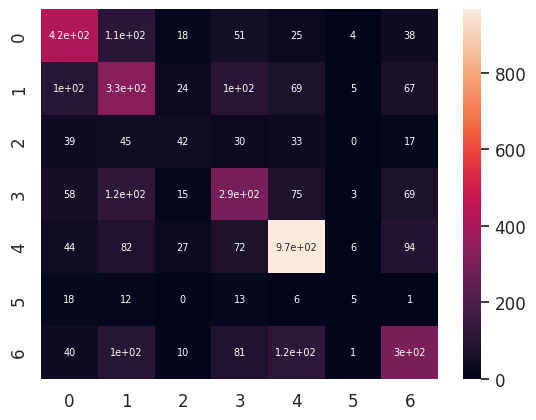

In [9]:
decision_tree_model = DecisionTreeClassifier(random_state = 0, max_depth = 11, criterion = "gini", class_weight = None)
evaluate_model(decision_tree_model, X_train, y_train)

Este modelo tiene un accuracy del `55%` lo que significa que clasifica correctamente el `55%` de las que predijo en total. En general la precision entre clases es esta distribuida en un amplio umbral desde `13%` y `74%`. En linea con lo anterior, es posible notar que `nick_fury` tiene un `13%` de preicision, que es una de las clases mas desbalanceadas del dataset (solo un `1%` de frecuencia). Por otro lado, se tiene que el recall esta distribuido entre `40%` y `70%` paratodas las clases excepto `hawkeye` y `nick_fury`, que son las dos clases con menor frecuencia en el dataset por diferencia, con un `15%` y `6%` de recall respectivamente. Esto significa que de las imagenes que se clasificaron como verdaderas positivas fueron muy pocas respecto a la cantidad total de verdaders positivos y falsos negativos. Finalmente, el f1-score varia entre un `40%` y un `70%` para todas las clases, excepto las dos mencionadas previamente, `hawkeye` y `nick_fury`, lo cual era esperable.

**Random Forest**


---

**Mejores parametros**:
`Best parameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 20, 'n_estimators': 200}`

***********************************************************
		Reporte de resultados: 

                 precision    recall  f1-score   support

    black_widow       0.68      0.78      0.73       665
captain_america       0.62      0.57      0.59       697
        hawkeye       0.69      0.24      0.35       206
           hulk       0.62      0.61      0.61       632
       iron_man       0.75      0.89      0.82      1291
      nick_fury       0.86      0.22      0.35        55
           thor       0.71      0.60      0.65       652

       accuracy                           0.69      4198
      macro avg       0.70      0.56      0.59      4198
   weighted avg       0.69      0.69      0.68      4198

***********************************************************


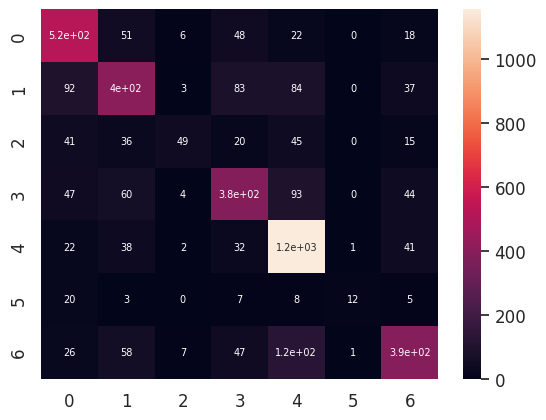

In [10]:
random_forest_model = RandomForestClassifier(random_state = 0, class_weight = "balanced", criterion = "entropy", max_depth = 20, n_estimators = 200)
evaluate_model(random_forest_model, X_train, y_train)

Para Random Forest hubo un `69%` de accuracy, lo que dice que del total de imagenes, el modelo predijo el `69%` correctamente. Respecto a la precision, es posible notar que es mucho mas uniforme y sin valores extremos, como si lo fue en arboles de decision. La precision varia entre un `60%` y un `90%`, indicando que en general se mejoro sustancialemente la capacidad de identificar falsos positivos. Respecto al recall es posible notar que existen dos clases con un valor menor al promedio. Estas clases son nuevamente las dos menos frecuentes del dataset: `hawkeye` y `nick_fury` con un `25%` y `22%` de recall respectivamente. Esto significa que el modelo, al igual que arboles de decision, no es muy robusto ante la deteccion de falsos negativos. Finalmente, como el recall fue malo para estas dos clases pero no asi su precision, se tiene que su f1-score fue medianamente malo con un `37%` y un `36%` respectivamente, auqne mejor que arboles de decision.

Ademas, es importante mencionar que la precision de `hawkeye` y `nick_fury` fueron las mas altas para todos los modelos, lo cual puede explicarse por el uso de balance de pesos para cada clase balanceado, lo cual es particularmente util para el estudio de este colab.

**Gradient Boosting**


---

**Mejores parametros**: `Best parameters: {'learning_rate': 0.1, 'loss': 'log_loss', 'n_estimators': 150}`

***********************************************************
		Reporte de resultados: 

                 precision    recall  f1-score   support

    black_widow       0.67      0.73      0.70       665
captain_america       0.55      0.55      0.55       697
        hawkeye       0.52      0.21      0.30       206
           hulk       0.56      0.54      0.55       632
       iron_man       0.76      0.86      0.81      1291
      nick_fury       0.38      0.15      0.21        55
           thor       0.62      0.56      0.59       652

       accuracy                           0.65      4198
      macro avg       0.58      0.51      0.53      4198
   weighted avg       0.64      0.65      0.64      4198

***********************************************************


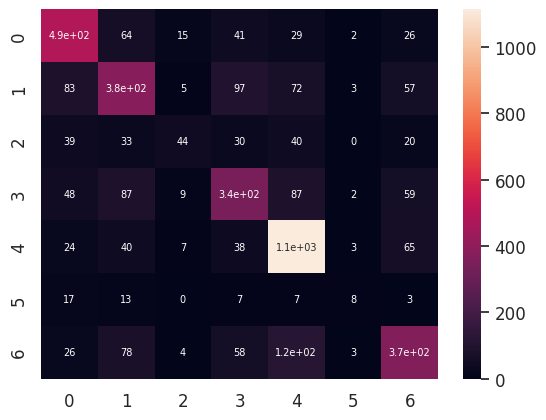

In [11]:
gradient_boosting_model = GradientBoostingClassifier(learning_rate = 0.1, loss = "log_loss", n_estimators = 150)
evaluate_model(gradient_boosting_model, X_train, y_train)

Para Gradient Boosting hubo un `65%` de accuracy, lo que dice que del total de imagenes, el modelo predijo el `65%` correctamente. Respecto a la precision, al igual que **Random Forest** se tene una distribucion relativamente uniforme sin valores extremos. Sin embargo, es posible notar que las dos peores clases siguen siendo las de `nick_fury` y `hack_eye`, aunque solo se alejan un `10%` de la media de precision. Por otro lado, el recall para ambas clases fue bastante bajo, con un `19%` y `13%` respectivamente, indicando que este modelo es muy poco robusto ante la deteccion de falsos negativos.

**KNN**


---

**Mejores parametros**: `Best parameters: {'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 11, 'p': 3, 'weights': 'distance'}`

***********************************************************
		Reporte de resultados: 

                 precision    recall  f1-score   support

    black_widow       0.39      0.34      0.36       665
captain_america       0.37      0.39      0.38       697
        hawkeye       0.39      0.15      0.22       206
           hulk       0.31      0.26      0.29       632
       iron_man       0.49      0.63      0.55      1291
      nick_fury       0.00      0.00      0.00        55
           thor       0.42      0.39      0.40       652

       accuracy                           0.42      4198
      macro avg       0.34      0.31      0.31      4198
   weighted avg       0.40      0.42      0.41      4198

***********************************************************


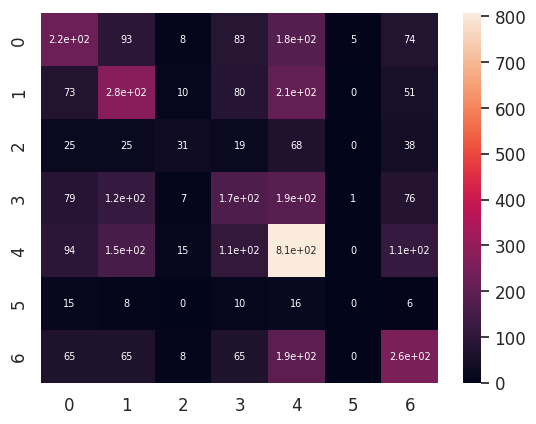

In [12]:
knn_model = KNeighborsClassifier(algorithm = "auto", metric = "manhattan", p = 3, weights = "distance", n_neighbors = 11)
evaluate_model(knn_model, X_train, y_train)

Para KNN hubo un `42%` de accuracy, lo que dice que del total de imagenes, el modelo predijo el `42%` correctamente. Respecto a la precision, se puede ver que es relativamente uniforme para valores entre `30%` y `40%`, pero con un caso extremo de `0%` de precision. Este caso se dio con `nick_fury` e implica que el modelo para esta clase es extremadamente malo para reconocer falsos positivos. Por otro lado, el recall para las dos peores clases es muy malo. En este caso la precison para `hawkeye` es media respecto a las demas precisiones, con un `38%` pero su recall es de un `16%`, lo cual implica que no hay tantos falsos positivos pero si muchos falsos negativos. Lo mismo ocurre con `hawkeye` pero a un nivel extremo, con un `0%` de recall. Esto implica que el modelo no fue capaz de generalizar predicciones para la clase menos frecuente del dataset, y funcionando con la misma tendencia para la segunda clase menos frecuente.

**SVM**


---

**Mejores parametros**: `Best parameters: {'C': 100, 'degree': 4, 'kernel': 'poly'}`

In [ ]:
svm_model = SVC(kernel='poly', C = 10, degree = 4)
evaluate_model(svm_model, X_train, y_train)

Para SVM hubo un `51%` de accuracy, lo que dice que del total de imagenes, el modelo predijo el `51%` correctamente. Respecto a la precision, esta esa casi tan balanceada como Random Forest, pero en recall se encuentra el peor resultado de los cinco modelos. `hawkeye` cuenta con un `40%` de precision pero solo `1%` de recall, lo que indica que no hubo muchos falsos positivos pero la relacion entre verdadero positivo y falso negativo es abrumadora.

# Actividad 5


---



 **Arboles de decision**


---

* **¿Cual es el error mas comun?**
1. confundir a `black_widow` con `captain_america`.
2. confundir `captain_america` con `black_widow` y `hulk`.
3. confundir a `hawkeye` con todas las clases menos `nick_fury`.
4. confundir a `hulk` con `captain_america`.
5. confundir a `iron_man` con `thor`.
6.  confundir a `nick_fury` con todo el resto de clases.
7. confundir a `thor` con `iron_man`.
* **¿Que Vengador tiene el mejor rendimiento?**
Los dos mejores f1-scores fueron obtenidos por `black_widow` y `iron_man` con un `60%` y `74%` respectivamente, y con un `60%` y `61%`, con un `74%` y `75%` para precision y recall respectivamente. Es decir, ambas clases fueron medianamente buenas y bastante consistentes entre precicios y recall, pudiendo identificar con menor cantidad de falsos positivos y menor cantidad de falsos negativo.
*  **¿Cual es el mas bajo?** Los dos mas bajos son `hawkeye` y `nick_fury`, que son los menos frecuentes en el dataset con un `5%` y `1%` respectivamente. El f1-score para ambos fue de `19%` y `8%`, respectivamente. Ademas cada uno tuvo una precisicion y recall de `27%` `19%` y `13%` `6%`, respectivamente. Lo anterior indica una alta cantidad de falsos positivos y una muy alta cantidad de falsos negativos para `hawkeye` y `nick_fury`.

* **¿Que Vengadores son los que se confunden mas comunmente?**
Los que se confunden mas comunmente son `nick_fury`, `hawkeye`, en ese orden. Es decir, aquellos con menor `recall` (ya que al haber una mayor cantidad de falsos neagtivos implica que la clase fue identificada como otra).


 **Random Forest**


---
* **¿Cual es el error mas comun?**
1. confundir a `hawkeye` con todas las clases menos `nick_fury` y `thor`.
6.  confundir a `nick_fury` con todo el resto de clases menos `hawkeye`.
7. confundir a `thor` con `iron_man`.
* **¿Que Vengador tiene el mejor rendimiento?**
Los dos mejores f1-scores fueron obtenidos por `black_widow` y `iron_man` con un `73%` y `82%` para recall respectivamente, y con un `67%`, `79%` y `75%` `90%` para precision y recall respectivamente. Esto indica que ambos modelos son medianamente buenos identificando falsos positivos y falsos negativos, en particular es el mejor modelo entrenado segun estas metricas. En particular, el recall de `iron_man` es excelente, siendo muy robusto ante la deteccion de falsos negativos.
*  **¿Cual es el mas bajo?** Los dos mas bajos son `hawkeye` y `nick_fury`, que son los menos frecuentes en el dataset con un `5%` y `1%` respectivamente. El f1-score para ambos fue de `37%` y `36%`, con una precisicion y recall de `74%` `25%`, `92%` y `22%`, respectivamente. Lo anterior indica que tanto `nick_fury` como `hawkeye` son muy buenos evitando falsos positivos pero muy poco robustos ante la deteccionde falsos negativos.

* **¿Que Vengadores son los que se confunden mas comunmente?**
Los que se confunden mas comunmente son `nick_fury` y `hawkeye`, en ese orden. Es decir, aquellos con menor `recall` (ya que al haber una mayor cantidad de falsos neagtivos implica que la clase fue identificada como otra).




 **Gradient Boosting**


---



* **¿Cual es el error mas comun?**
1. confundir a `hawkeye` con todas las clases menos `nick_fury`.
4.  confundir a `nick_fury` con todas las clases menos `hawkeye`.
5. confundir a `thor` con `iron_man`.
* **¿Que Vengador tiene el mejor rendimiento?**
 Los dos mejores f1-scores fueron obtenidos por `black_widow` y `iron_man` con un 70% y 81% para recall respectivamente, y con un 68%, 72% y 76% 87% para precision y recall respectivamente. Esto indica que ambos modelos son medianamente buenos identificando falsos positivos y falsos negativos, en particular es el mejor modelo entrenado segun estas metricas.
*  **¿Cual es el mas bajo?** Los dos mas bajos son `hawkeye` y `nick_fury`, que son los menos frecuentes en el dataset con un `5%` y `1%` respectivamente. El f1-score para ambos fue de `27%` y `20%`, con una precisicion y recall de `47%` `19%` y `47%` `13%`, respectivamente. Lo anterior indica una capacidad medianamente mala de identificar falsos positivos pero una bastante mala para identificar falsos negativos.

* **¿Que Vengadores son los que se confunden mas comunmente?**
Los que se confunden mas comunmente son `nick_fury` y`hawkeye`, en ese orden. Es decir, aquellos con menor `recall` (ya que al haber una mayor cantidad de falsos neagtivos implica que la clase fue identificada como otra).





 **KNN**


---

* **¿Cual es el error mas comun?**
1. confundir a `black_widow` con `iron_man`.
2. confundir `captain_america` con `iron_man`.
3. confundir a `hawkeye` con rodas las clases menos `nick_fury`
4. confundir a `hulk` con `iron_man`
5. confindir a `iron_man` con `captain_america`, `hulk` o `thor`.
6.  confundir a `nick_fury` con todo el resto de clases menos `hawkeye`
7. confundir a `thor` con `iron_man`.
* **¿Que Vengador tiene el mejor rendimiento?**
Los dos mejores f1-scores fueron obtenidos por `iron_man` con un `55%` de  recall , y con un `48%`, `64%` para precision y recall respectivamente. Es decir, se tiene que esta clase es reconoce un falso positivo la mitad de las veces, y es medianamente buena para reconocer falsos negativos.
*  **¿Cual es el mas bajo?** La peor clase es `nick_fury`. El f1-score fue de `0%`, con una precisicion y recall de `0%` para ambos. Lo anterior indica que **KNN** es extremadamente sensible ante clases con gran desbalance, ya que no pudo identificar correctamente ninguna foto de `nick_fury`.

* **¿Que Vengadores son los que se confunden mas comunmente?**
La clase que mas se confunde por lejos es `nick_fury`. Es decir, es aquella con el menor `recall` (ya que al haber una mayor cantidad de falsos neagtivos implica que la clase fue identificada como otra).


 **SVM**


---
* **¿Cual es el error mas comun?**
1. confundir `captain_america` con `black_widow` o `iron_man`.
2. confundir a `hawkeye` con todas las clases menos `nick_fury`.
3. confundir a `hulk` con `iron_man`
5.  confundir a `nick_fury` con todo el resto de clases menos `hawkeye` y `thor`
7. confundir a `thor` con `iron_man`.
* **¿Que Vengador tiene el mejor rendimiento?**
Los dos mejores f1-scores fueron obtenidos por `black_widow` y `iron_man` con un `62%` y `67%` para recall respectivamente, y con un `57%`, `68%` y `53%` `91%` para precision y recall respectivamente. Respecto al recall de `iron_man`, es posible afirmar que se tiene una muy baja cantidad de falsos negativos, lo cual se puede apreciar en la matriz de confusion donde es confundido muy pocas veces. Es decir son las clase que es identificada con menor cantidad de falsos positivos y menor cantidad de falsos negativos.
*  **¿Cual es el mas bajo?** Los dos mas bajos son `hawkeye` y `nick_fury`, que son los menos frecuentes en el dataset con un `5%` y `1%` respectivamente. El f1-score para ambos fue de `2%` y `14%`, con una precisicion y recall de `40%` `1%` y `67%` `8%`, respectivamente. Lo anterior indica una cantidad media de falsos positivos para `hawkeye` y media baja para `nick_fury`. Por otro lado, `hawkeye` cuenta con una muy baja cantidad de verdaderos positivos, con una abrumante cantidad de falsos positivos.

* **¿Que Vengadores son los que se confunden mas comunmente?**
Los que se confunden mas comunmente son `hawkeye`, `nick_fury`, en ese orden. Es decir, aquellos con menor `recall` (ya que al haber una mayor cantidad de falsos neagtivos implica que la clase fue identificada como otra).



### **Discusion de resultados**


---
Luego de analizar los resultados podemos notar que el orden de accuracy fue el siguiente:
1. **Random Forest** (`69%`)
2. **Gradient Boosting** (`65%`)
3. **Arboles de decision** (`55%`)
4. **SVM** (`51%`)
5. **KNN** (`42%`)

Sin embargo el `accuracy` no es la unica metrica a considerar. En particular, se observo que **Random Forest** obtuvo el mayor valor de `f1-score` (`69%`) entre los modelos evaluados, lo que indica un buen balance entre `precision` y `recall` (`72%` y `56%` en promedio para ambos respectivamente). A pesar de lo anterior, el `recall` para `hawkeye` fue de `25%` y para `nick_fury` fue de `22%`, siendo las dos clases con menor frecuencia en el dataset (`5%` y `1%` respectivamente). Esto indica un modelo poco robusto ante la deteccion de falsos negativos. Por otro lado, sin considerar estas dos clases, el `recall` fue de `68%`.

Respecto al ranking de accuracies, se puede explicar por las caracteristicas de cada modelo y como se ajustan a los datos. El **random forest** tuvo el mejor `accuracy` porque combina la prediccion de muchos arboles de decision (`200` donde cada uno tuvo una profundida de de `20`, usando balance de clases) en este caso que usan diferentes partes de los datos, usando pesos balanceados para cada clase y diferentes caracteristicas, lo que reduce la varianza y el riesgo de sobreajuste. El **gradient boosting** quedo en segundo lugar porque tambien combina varios arboles de decision (`150` en este caso), pero en este caso cada arbol aprende de los errores del anterior (en un rate de `0.1`) y trata de mejorarlos, intentando optimizar una funcion de perdida (`log_loss`). Los arboles de decision individuales quedaron en tercer lugar porque son capaces de capturar las interacciones y dependencias entre las caracteristicas, pero pueden sufrir de sobreajuste si el arbol es muy profundo o complejo. Finalmente, los dos peores modelos fueron **SVM** y
**KNN**, que tuvieron dificultades para separar las clases, posiblemente porque las clases no eran linealmente separables o se solapaban en el espacio de caracteristicas.  Para **SVM** se probaron diferentes tipos de `kernel` (`['linear', 'poly', 'rbf', 'sigmoid']`) pero ninguno logro mejorar significativamente el desempeno. Esto puede deberse a que ningun `kernel` se ajusto bien a el espacio de los datos y no se pudo trazar un buen hiperplano. Ademas se probo con diversos valores para `C` sin una majoera significativa. Por orto lado, **KNN** cuenta con el parametros `n_neighbors` que indica cuantas de las muestras mas cercanas se usaran para definir la clase. Se probo con diversos valores (`[1, 3, 7, 9, 11, 15, 17, 19, 21, 23, 25, 27, 29, 35, 45, 55]`), donde `11` vecinos y usando distancia de `manhattan` retorno el `accuracy` mas alto, que a su vez fue el mas bajo de todos los modelos (`42%`). Lo anterior puede deberse a que los datos estan considerablemente mezclados entre si y **KNN** no es capaz de identificar correctamente clases.


# Actividad 6


---


### Instalacion de `lime`


---



In [16]:
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Imports necesarios


---



In [15]:
from lime import lime_tabular

In [35]:
feature_names = ["eye_eyebrow_ratio1", "eyebrow_chin_ratio1",
            "nose_face_relation1", "eye_mouth_relation1", "chin_points_to_nose_variance1",
            "eyebrows_to_eyes_variance1", "face_width_to_height_ratio1",
            "eyebrows_to_nose_variance1", "chin_to_nose_variance1", "get_encoding1"]
class_names = ['black_widow', 'captain_america', 'hawkeye', 'hulk', 'iron_man', 'nick_fury', 'thor']
class_names2 = ['iron_man', 'captain_america', 'black_widow', 'thor', 'hulk', 'hawkeye', 'nick_fury']

>Para la realizacion de esta actividad me base en este [articulo](https://betterdatascience.com/lime/)

### Motivacion


---

Los modelos suelen ser internamente muy complejos y no se suele entender su toma de decisiones ni las consecuencias que estos producen, junto con el verdadero razonamiento de los resultados. Esto no dificulta entenderlos lo suficiente para mejorar su calidad. Por eso se hace necesario tener una forma de explicar las predicciones de los modelos, y eso es lo que hace precisamente LIME. LIME muestra que características son las mas importantes para cada prediccion, permitiendo tener una idea de la logica del modelo para poder modificar hiperparametros y caracteristicas.

Ahora, a partir los modelos ya entrenados con validacion cruzada en la actividad 4, se crearean objetos de tipo `tabular explainer object`, que vienen de la libreria `lime`. Este espera los siguiente parametros:
1. `training_data`: correspondiente al `X_train` obtenido de `split_train_test`.
2. `feature_names`: columna con los nombres de las features.
3. `class_names`: columna con los nombres de las clases.
4. `mode`: que indica el tipo de problema que se esta resolviendo. En el caso de este colab se trata de un problema de clasificacion.

Lo anterior se puede ver en la siguiente celda:

In [33]:
#Codigo extraido de https://betterdatascience.com/lime/

explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=feature_names,
    class_names=class_names,
    mode='classification'
)

Ahora, se puede llamar a la instancia `explainer` y ejecutar su metodo `explain_instance` que requiere los siguientes parametors:

1. `data_row`: que corresponde a una observacion del dataset
2. `predict_fn`:  que corresponde a la funcion uada para hacer las predicciones. A ella se le entrega el modelo que se quiera estudiar y le aplica `predict_proba ` para mostrar probabilidades.

A continuacion lo anterior en codigo, que se probara para el primer elemento de `X_test`:

In [59]:
X_test.iloc[1]

0     0.546237
1     0.832413
2     0.406104
3     1.332088
4    99.245854
5     2.704685
6     1.276345
7    42.032464
8    99.245854
9    -0.004006
Name: 2621, dtype: float64

Que corresponde a la etiqueta:

In [60]:
y[2621]

'black_widow'

## **Arboles de decision**

In [55]:
#Codigo extraido de https://betterdatascience.com/lime/ y para el resto de modelos se sigue la misma idea
#MODELO: decision_tree_model

exp = explainer.explain_instance(
    data_row=X_test.iloc[1],
    predict_fn=decision_tree_model.predict_proba,
    top_labels=7
)

exp.show_in_notebook(show_table=True)

Ahora se estudiara el output. Tenemos que en general existen tres secciones:

1. **Prediction probabilities**
2. **Detalle de eleccion de caracteristicas para cada clase en una instancia de `X_train`**
3. **Feature Value**

**Prediction probabilities**


---
Es las seccion de mas a la izquierda para el output superior. En el se muestran los porcentajes de prediccion del modelo para cada clase en una instancia. Para el caso de `arboles de decision` en la primera instancia de `X_train` se tiene que el modelo esta un `56%` seguro de que la clase correspone a `captain_america`, con un `15%` de seguridad corresponde a `black_widow` (la cual efectivamente es la clase correcta), y asi para el resto.








**Detalle de caracteristicas**


---



Para esta seccion y para cada clase, se tiene un detalle de el peso que tiene cada caracteristica junto con su prediccion: es o no es la clase. Si se observa el detalle para la primera clase `captain_america`, se tiene que las 10 features se dividen en que tanto aportan para decidir si se clasifica o no como `captain_america`.

Se analizaran dos clases: la que se predijo mal y la que verdaderamente era.
1. **Clase erronea (`captain_america`)**

Tenemos que las caracteristicas mas predominantes a la hora de determinar si se trata de `captain_america` por sobre `black_widow` fueron:


*   `get_encoding (8%)`
*   `eye_eyebrow_ratio (8%)`
* `eyebrows_to_nose_variance (7%)`

Donde la primera representa el encoding de la imagen usando la libreria
`face_recognition`, la segunda representa el radio entre la distancia los puntos medios de los ojos y los extremos de las cejas, y la ultima represnta la varianza de las distancias desde el punto medio de la nariz a cada punto de las cejas.





2. **Clase real (`black_widow`)**
Ahora, las caracteristicas con mas peso a la hora de decidir si se trata de `black_widow` fueron:

*   `get_encoding (6%)`
*   `eye_eyebrow_ratio (3%)`
* `eyebrow_chin_ratio (2%)`
Donde las primeras dos se describieron en el punto anterior, y la tercera representa el radio entre el largo de las cejas al punto medio de la nariz y el largo del centro de la barbilla al punto medio de la nariz.


Es posible notar que las dos caracteristicas mas predominantes son compartidas en estas dos clases, lo que puede explicar la confusion del modelo.


**Feature Value**


---



Finalmente se tiene un ranking de las features mas influyentes. Para el caso de esta instancia y `arboles de decision` el orden de las tres mas predominantes es:


1.  `get_encoding`

2. `eye_eyebrow_ratio`

3. `eyebrows_to_nose_variance`




## **Random Forest**





In [56]:
exp = explainer.explain_instance(
    data_row=X_test.iloc[1],
    predict_fn=random_forest_model.predict_proba,
    top_labels=7
)

exp.show_in_notebook(show_table=True)

**Prediction probabilities**


---
Para el caso de la misma instancia pero usando `random_forest_model`, tenemos que el modelo tiene solo un `29%` de confianza de que se trata de `black_widow` (la clase correcta), un `24%` de `captain_america` y un `19%` `thor`, y asi para el resto de clases. Aca se puede apreciar que con el ensamble de muchos arboles, es posible corregir los errores de algunos y llegar al label correcto. Para el caso del arbol de decision del punto anterior, se tuvo que al menos se considero en segundo lugar a `black_widow` pero se le dio mucho mas peso a las caracteristicas de tal forma que se termino por elegir a `captain_america`.







**Detalle de caracteristicas**


---

En este caso, se tiene que la distribucion de probabilidad esta bastante pareja. Sin embargo, al analizar las primeras tres clases mas probables, se tiene que todas comparten `get_encoding` pero difieren del resto de caracteristicas, indicando una gran diversidad de consideracion de opciones por parte del modelo. En particular `get_encoding` fue dominante en la decision de las dos clases mas probables, con un `5%` y `6%` respectivamente. Respecto a la tercera clase, se tuvo que la feature predominante fue `face_width_to_height_ratio` con  un `6%` que corresponde a la razon entre el ancho y largo de la cara.



**Feature Value**

---

En este caso, el orden de las tres features mas importantes fue:

1. `get_encoding`
2. `chin_points_to_nose_variance`
3. `eyebrow_chin_ratio`

donde solo el primero fue parte del top 3 de arboles de decision. Lo cual indica cierto grado de diversidad de importancia en features.

## **Gradient Boosting**

In [57]:
exp = explainer.explain_instance(
    data_row=X_test.iloc[1],
    predict_fn=gradient_boosting_model.predict_proba,
    top_labels=7
)

exp.show_in_notebook(show_table=True)

**Prediction probabilities**


---
Para `gradient_boosting_modelo`, se tiene que el modelo predice con un `32%` de confianza que se trata de `thor`, un `21%` de `captain_america` y un `15%` `hulk`, y asi para el resto de clases. Podemos notar que ni siquiera se considero al label.






**Detalle de caracteristicas**


---

En este caso, al analizar la clase por la cual se confundio el modelo, podemos notar que la feature mas relevante es `face_width_to_height_ratio` con un `9%`. Luego se tiene una caracteristica con bastante peso para determinar que no se trata de `thor`, que corresponde a `eyebrows_to_eyes_variance` con un `8%`. Al analizar con mas detalle las features elegidas para `black_widow`, podemos notar que la mas relevante es `chin_points_to_nose_variance` que con un `5%` indica que no se trata de ` black_widow`.

**Feature Value**

---

En este caso, el orden de las tres features mas importantes fue:

1. `face_width_to_height_ratio`
2. `eyebrows_to_eyes_variance`
3. `get_encoding`

donde solo el tercero fue parte del top 3 de arboles de decision o de random forest. Lo cual indica cierto grado de diversidad de importancia en features.

## **KNN**

In [58]:
exp = explainer.explain_instance(
    data_row=X_test.iloc[1],
    predict_fn=knn_model.predict_proba,
    top_labels=7
)

exp.show_in_notebook(show_table=True)

**Prediction probabilities**


---
Para `knn_model`, se tiene que el modelo predice con un `38%` de confianza que se trata de `thor`, un `20%` de `black_widow`, un `17%` `thor`, un `15%` `hawkeye` y asi para el resto de clases.







**Detalle de caracteristicas**


---



Para **KNN** ocurre algo intersante y es que una  de las caracteristicas mas predonminantes, `get_encoding`, no es si quiera considerada en las tres clases mas probables. Por otro lado, podemos notar que con un `11%` de certeza se puede determinar que no se trata de `iron_man` a traves de la feature `eyebrows_to_nose_variance` y con un `7%` de que si se trata de `iron_man` a traves de la feature `eyebrows_to_eyes_variance`. Respecto a `black_widow`, podemos notar que dos de las features mas importantes corresponden a `eyebrows_to_eyes_variance` y `chin_points_to_nose_variance`, donde la primera tambien esta presente en `iron_man`, lo cual pudo haber causado confusion a la hora de calcula los `11` vecinos mas cercanos, que fueron usados como parametro.




**Feature Value**

---
1. `eyebrows_to_nose_variance`
2. `eyebrows_to_eyes_variance`
3. `chin_points_to_nose_variance`

Un punto intersante a considerar de este top es que no se cuenta con `get_encoding` y que todas las featuers se tratan de varianzas.

ㅤ

ㅤ

ㅤ





# Fuentes consultadas


---



1.   [Funcionamiento de pandas en general](https://pandas.pydata.org/Pandas_Cheat_Sheet.pdf)

2. [Obtener una muestra aleatoria por clase en un dataframe](https://stackoverflow.com/questions/41345289/getting-a-random-sample-in-python-dataframe-by-category)

3.  [Iterar en un dataframe](https://stackoverflow.com/questions/16476924/how-to-iterate-over-rows-in-a-dataframe-in-pandas/)

4. [Ploteo de multiples figuras y elementos](https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html
)
5.  [Ayudantias del curso](https://github.com/IIC2613-Inteligencia-Artificial-2023-1/Syllabus/tree/main)

6. [Documentacion Arboles de Decision](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)

7. [Documentacion Random Forests](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

8. [Documentacion Gradient Boosting](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)

9. [Articulo sobre busqueda de hiperparametros usando sklearn](https://scikit-learn.org/stable/modules/grid_search.html)

10. [Documentacion GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

11. [Ejemplos de GridSearchCV](https://www.programcreek.com/python/example/91151/sklearn.model_selection.GridSearchCV)

12. [Documentacion KNN](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

13. [Documentacion SVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

14. [Matriz de confusion usando validacion cruzada](https://stackoverflow.com/questions/40057049/using-confusion-matrix-as-scoring-metric-in-cross-validation-in-scikit-learn)

15. [Plotting de matrices de confusion](https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix)

16. [Uso de LIME](https://betterdatascience.com/lime/)